# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [7]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [8]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [10]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[FILL THIS IN]


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [11]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [12]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [15]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [16]:
model = TwoLayerNet()
solver = None
best_val = 0

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rate = [1e-5, 1e-4, 1e-3, 1e-2]

for lr in learning_rate:
    s = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': lr,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=1000)
    s.train()
    if s.best_val_acc > best_val:
        best_val = s.best_val_acc
        solver = s
    
print("learning rate: %e, acc: %f" % (solver.optim_config['learning_rate'], solver.best_val_acc))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.086000; val_acc: 0.064000
(Iteration 2 / 4900) loss: 2.306222
(Iteration 3 / 4900) loss: 2.306003
(Iteration 4 / 4900) loss: 2.308731
(Iteration 5 / 4900) loss: 2.306651
(Iteration 6 / 4900) loss: 2.305969
(Iteration 7 / 4900) loss: 2.305454
(Iteration 8 / 4900) loss: 2.300759
(Iteration 9 / 4900) loss: 2.304767
(Iteration 10 / 4900) loss: 2.306343
(Iteration 11 / 4900) loss: 2.307660
(Iteration 12 / 4900) loss: 2.305088
(Iteration 13 / 4900) loss: 2.305632
(Iteration 14 / 4900) loss: 2.305692
(Iteration 15 / 4900) loss: 2.301525
(Iteration 16 / 4900) loss: 2.307225
(Iteration 17 / 4900) loss: 2.308100
(Iteration 18 / 4900) loss: 2.305623
(Iteration 19 / 4900) loss: 2.301696
(Iteration 20 / 4900) loss: 2.305696
(Iteration 21 / 4900) loss: 2.308033
(Iteration 22 / 4900) loss: 2.308272
(Iteration 23 / 4900) loss: 2.305629
(Iteration 24 / 4900) loss: 2.306767
(Iteration 25 / 4900) loss: 2.303919
(Iteration 26 / 4900) loss: 2.

(Iteration 218 / 4900) loss: 2.297772
(Iteration 219 / 4900) loss: 2.297264
(Iteration 220 / 4900) loss: 2.299296
(Iteration 221 / 4900) loss: 2.297579
(Iteration 222 / 4900) loss: 2.299137
(Iteration 223 / 4900) loss: 2.300103
(Iteration 224 / 4900) loss: 2.295380
(Iteration 225 / 4900) loss: 2.297534
(Iteration 226 / 4900) loss: 2.296721
(Iteration 227 / 4900) loss: 2.294010
(Iteration 228 / 4900) loss: 2.295059
(Iteration 229 / 4900) loss: 2.295011
(Iteration 230 / 4900) loss: 2.293765
(Iteration 231 / 4900) loss: 2.298428
(Iteration 232 / 4900) loss: 2.294259
(Iteration 233 / 4900) loss: 2.297441
(Iteration 234 / 4900) loss: 2.297499
(Iteration 235 / 4900) loss: 2.297239
(Iteration 236 / 4900) loss: 2.294714
(Iteration 237 / 4900) loss: 2.295033
(Iteration 238 / 4900) loss: 2.298641
(Iteration 239 / 4900) loss: 2.296558
(Iteration 240 / 4900) loss: 2.290575
(Iteration 241 / 4900) loss: 2.294571
(Iteration 242 / 4900) loss: 2.286636
(Iteration 243 / 4900) loss: 2.295567
(Iteration 2

(Iteration 433 / 4900) loss: 2.288648
(Iteration 434 / 4900) loss: 2.285878
(Iteration 435 / 4900) loss: 2.286786
(Iteration 436 / 4900) loss: 2.284628
(Iteration 437 / 4900) loss: 2.282184
(Iteration 438 / 4900) loss: 2.288408
(Iteration 439 / 4900) loss: 2.280209
(Iteration 440 / 4900) loss: 2.279541
(Iteration 441 / 4900) loss: 2.281877
(Iteration 442 / 4900) loss: 2.285513
(Iteration 443 / 4900) loss: 2.284823
(Iteration 444 / 4900) loss: 2.288482
(Iteration 445 / 4900) loss: 2.281018
(Iteration 446 / 4900) loss: 2.285876
(Iteration 447 / 4900) loss: 2.278939
(Iteration 448 / 4900) loss: 2.287417
(Iteration 449 / 4900) loss: 2.280053
(Iteration 450 / 4900) loss: 2.281125
(Iteration 451 / 4900) loss: 2.277352
(Iteration 452 / 4900) loss: 2.284253
(Iteration 453 / 4900) loss: 2.280650
(Iteration 454 / 4900) loss: 2.284300
(Iteration 455 / 4900) loss: 2.280094
(Iteration 456 / 4900) loss: 2.279416
(Iteration 457 / 4900) loss: 2.279171
(Iteration 458 / 4900) loss: 2.284536
(Iteration 4

(Iteration 647 / 4900) loss: 2.257925
(Iteration 648 / 4900) loss: 2.271355
(Iteration 649 / 4900) loss: 2.281597
(Iteration 650 / 4900) loss: 2.276772
(Iteration 651 / 4900) loss: 2.271338
(Iteration 652 / 4900) loss: 2.269034
(Iteration 653 / 4900) loss: 2.273058
(Iteration 654 / 4900) loss: 2.263730
(Iteration 655 / 4900) loss: 2.272779
(Iteration 656 / 4900) loss: 2.261295
(Iteration 657 / 4900) loss: 2.270800
(Iteration 658 / 4900) loss: 2.262263
(Iteration 659 / 4900) loss: 2.267462
(Iteration 660 / 4900) loss: 2.275007
(Iteration 661 / 4900) loss: 2.269505
(Iteration 662 / 4900) loss: 2.258738
(Iteration 663 / 4900) loss: 2.267349
(Iteration 664 / 4900) loss: 2.276556
(Iteration 665 / 4900) loss: 2.267677
(Iteration 666 / 4900) loss: 2.272009
(Iteration 667 / 4900) loss: 2.280774
(Iteration 668 / 4900) loss: 2.268312
(Iteration 669 / 4900) loss: 2.269520
(Iteration 670 / 4900) loss: 2.252614
(Iteration 671 / 4900) loss: 2.259195
(Iteration 672 / 4900) loss: 2.260580
(Iteration 6

(Iteration 862 / 4900) loss: 2.240035
(Iteration 863 / 4900) loss: 2.254315
(Iteration 864 / 4900) loss: 2.250476
(Iteration 865 / 4900) loss: 2.259181
(Iteration 866 / 4900) loss: 2.254539
(Iteration 867 / 4900) loss: 2.241595
(Iteration 868 / 4900) loss: 2.265011
(Iteration 869 / 4900) loss: 2.259420
(Iteration 870 / 4900) loss: 2.264872
(Iteration 871 / 4900) loss: 2.254416
(Iteration 872 / 4900) loss: 2.251195
(Iteration 873 / 4900) loss: 2.255795
(Iteration 874 / 4900) loss: 2.264815
(Iteration 875 / 4900) loss: 2.251963
(Iteration 876 / 4900) loss: 2.252293
(Iteration 877 / 4900) loss: 2.251639
(Iteration 878 / 4900) loss: 2.247976
(Iteration 879 / 4900) loss: 2.255757
(Iteration 880 / 4900) loss: 2.258709
(Iteration 881 / 4900) loss: 2.260823
(Iteration 882 / 4900) loss: 2.242068
(Iteration 883 / 4900) loss: 2.255727
(Iteration 884 / 4900) loss: 2.244104
(Iteration 885 / 4900) loss: 2.255031
(Iteration 886 / 4900) loss: 2.248270
(Iteration 887 / 4900) loss: 2.240149
(Iteration 8

(Iteration 1074 / 4900) loss: 2.213426
(Iteration 1075 / 4900) loss: 2.228293
(Iteration 1076 / 4900) loss: 2.237148
(Iteration 1077 / 4900) loss: 2.214544
(Iteration 1078 / 4900) loss: 2.216332
(Iteration 1079 / 4900) loss: 2.232817
(Iteration 1080 / 4900) loss: 2.240846
(Iteration 1081 / 4900) loss: 2.215786
(Iteration 1082 / 4900) loss: 2.251787
(Iteration 1083 / 4900) loss: 2.236718
(Iteration 1084 / 4900) loss: 2.244835
(Iteration 1085 / 4900) loss: 2.259706
(Iteration 1086 / 4900) loss: 2.209062
(Iteration 1087 / 4900) loss: 2.224743
(Iteration 1088 / 4900) loss: 2.226594
(Iteration 1089 / 4900) loss: 2.213250
(Iteration 1090 / 4900) loss: 2.243612
(Iteration 1091 / 4900) loss: 2.262109
(Iteration 1092 / 4900) loss: 2.240552
(Iteration 1093 / 4900) loss: 2.239804
(Iteration 1094 / 4900) loss: 2.217199
(Iteration 1095 / 4900) loss: 2.248882
(Iteration 1096 / 4900) loss: 2.241300
(Iteration 1097 / 4900) loss: 2.207861
(Iteration 1098 / 4900) loss: 2.252133
(Iteration 1099 / 4900) l

(Iteration 1284 / 4900) loss: 2.202452
(Iteration 1285 / 4900) loss: 2.214313
(Iteration 1286 / 4900) loss: 2.251025
(Iteration 1287 / 4900) loss: 2.211918
(Iteration 1288 / 4900) loss: 2.208028
(Iteration 1289 / 4900) loss: 2.216000
(Iteration 1290 / 4900) loss: 2.201247
(Iteration 1291 / 4900) loss: 2.180631
(Iteration 1292 / 4900) loss: 2.163517
(Iteration 1293 / 4900) loss: 2.204395
(Iteration 1294 / 4900) loss: 2.223022
(Iteration 1295 / 4900) loss: 2.215588
(Iteration 1296 / 4900) loss: 2.237596
(Iteration 1297 / 4900) loss: 2.179242
(Iteration 1298 / 4900) loss: 2.186021
(Iteration 1299 / 4900) loss: 2.203459
(Iteration 1300 / 4900) loss: 2.224785
(Iteration 1301 / 4900) loss: 2.188038
(Iteration 1302 / 4900) loss: 2.191541
(Iteration 1303 / 4900) loss: 2.256289
(Iteration 1304 / 4900) loss: 2.217043
(Iteration 1305 / 4900) loss: 2.189038
(Iteration 1306 / 4900) loss: 2.207305
(Iteration 1307 / 4900) loss: 2.172553
(Iteration 1308 / 4900) loss: 2.208079
(Iteration 1309 / 4900) l

(Iteration 1492 / 4900) loss: 2.192313
(Iteration 1493 / 4900) loss: 2.153407
(Iteration 1494 / 4900) loss: 2.183290
(Iteration 1495 / 4900) loss: 2.172377
(Iteration 1496 / 4900) loss: 2.196301
(Iteration 1497 / 4900) loss: 2.178843
(Iteration 1498 / 4900) loss: 2.184718
(Iteration 1499 / 4900) loss: 2.183532
(Iteration 1500 / 4900) loss: 2.166927
(Iteration 1501 / 4900) loss: 2.204173
(Iteration 1502 / 4900) loss: 2.148043
(Iteration 1503 / 4900) loss: 2.161087
(Iteration 1504 / 4900) loss: 2.204456
(Iteration 1505 / 4900) loss: 2.201853
(Iteration 1506 / 4900) loss: 2.169830
(Iteration 1507 / 4900) loss: 2.191164
(Iteration 1508 / 4900) loss: 2.171042
(Iteration 1509 / 4900) loss: 2.173029
(Iteration 1510 / 4900) loss: 2.203872
(Iteration 1511 / 4900) loss: 2.206497
(Iteration 1512 / 4900) loss: 2.162413
(Iteration 1513 / 4900) loss: 2.200798
(Iteration 1514 / 4900) loss: 2.176056
(Iteration 1515 / 4900) loss: 2.208729
(Iteration 1516 / 4900) loss: 2.210167
(Iteration 1517 / 4900) l

(Iteration 1702 / 4900) loss: 2.154704
(Iteration 1703 / 4900) loss: 2.156300
(Iteration 1704 / 4900) loss: 2.207538
(Iteration 1705 / 4900) loss: 2.168080
(Iteration 1706 / 4900) loss: 2.125270
(Iteration 1707 / 4900) loss: 2.185606
(Iteration 1708 / 4900) loss: 2.193792
(Iteration 1709 / 4900) loss: 2.159256
(Iteration 1710 / 4900) loss: 2.180713
(Iteration 1711 / 4900) loss: 2.267392
(Iteration 1712 / 4900) loss: 2.184039
(Iteration 1713 / 4900) loss: 2.124431
(Iteration 1714 / 4900) loss: 2.146755
(Iteration 1715 / 4900) loss: 2.196025
(Iteration 1716 / 4900) loss: 2.192428
(Iteration 1717 / 4900) loss: 2.111193
(Iteration 1718 / 4900) loss: 2.194984
(Iteration 1719 / 4900) loss: 2.133492
(Iteration 1720 / 4900) loss: 2.223596
(Iteration 1721 / 4900) loss: 2.175478
(Iteration 1722 / 4900) loss: 2.167637
(Iteration 1723 / 4900) loss: 2.176178
(Iteration 1724 / 4900) loss: 2.159394
(Iteration 1725 / 4900) loss: 2.177838
(Iteration 1726 / 4900) loss: 2.174205
(Iteration 1727 / 4900) l

(Iteration 1912 / 4900) loss: 2.150908
(Iteration 1913 / 4900) loss: 2.144399
(Iteration 1914 / 4900) loss: 2.112816
(Iteration 1915 / 4900) loss: 2.156277
(Iteration 1916 / 4900) loss: 2.105629
(Iteration 1917 / 4900) loss: 2.132785
(Iteration 1918 / 4900) loss: 2.124614
(Iteration 1919 / 4900) loss: 2.113128
(Iteration 1920 / 4900) loss: 2.108095
(Iteration 1921 / 4900) loss: 2.136286
(Iteration 1922 / 4900) loss: 2.135978
(Iteration 1923 / 4900) loss: 2.161364
(Iteration 1924 / 4900) loss: 2.093342
(Iteration 1925 / 4900) loss: 2.175656
(Iteration 1926 / 4900) loss: 2.103936
(Iteration 1927 / 4900) loss: 2.171211
(Iteration 1928 / 4900) loss: 2.121249
(Iteration 1929 / 4900) loss: 2.125517
(Iteration 1930 / 4900) loss: 2.170236
(Iteration 1931 / 4900) loss: 2.127837
(Iteration 1932 / 4900) loss: 2.201575
(Iteration 1933 / 4900) loss: 2.162684
(Iteration 1934 / 4900) loss: 2.211106
(Iteration 1935 / 4900) loss: 2.102546
(Iteration 1936 / 4900) loss: 2.090411
(Iteration 1937 / 4900) l

(Iteration 2120 / 4900) loss: 2.110252
(Iteration 2121 / 4900) loss: 2.084347
(Iteration 2122 / 4900) loss: 2.106996
(Iteration 2123 / 4900) loss: 2.114611
(Iteration 2124 / 4900) loss: 2.141462
(Iteration 2125 / 4900) loss: 2.057665
(Iteration 2126 / 4900) loss: 2.172562
(Iteration 2127 / 4900) loss: 2.129212
(Iteration 2128 / 4900) loss: 2.148652
(Iteration 2129 / 4900) loss: 2.051424
(Iteration 2130 / 4900) loss: 2.176094
(Iteration 2131 / 4900) loss: 2.085145
(Iteration 2132 / 4900) loss: 2.072655
(Iteration 2133 / 4900) loss: 2.116086
(Iteration 2134 / 4900) loss: 2.112349
(Iteration 2135 / 4900) loss: 2.079613
(Iteration 2136 / 4900) loss: 2.136991
(Iteration 2137 / 4900) loss: 2.144384
(Iteration 2138 / 4900) loss: 2.142660
(Iteration 2139 / 4900) loss: 2.092407
(Iteration 2140 / 4900) loss: 2.128953
(Iteration 2141 / 4900) loss: 2.146354
(Iteration 2142 / 4900) loss: 2.103059
(Iteration 2143 / 4900) loss: 2.087409
(Iteration 2144 / 4900) loss: 2.076347
(Iteration 2145 / 4900) l

(Iteration 2330 / 4900) loss: 2.112117
(Iteration 2331 / 4900) loss: 2.079803
(Iteration 2332 / 4900) loss: 2.156812
(Iteration 2333 / 4900) loss: 2.113133
(Iteration 2334 / 4900) loss: 2.094447
(Iteration 2335 / 4900) loss: 2.159458
(Iteration 2336 / 4900) loss: 2.141283
(Iteration 2337 / 4900) loss: 2.156206
(Iteration 2338 / 4900) loss: 2.116472
(Iteration 2339 / 4900) loss: 2.057945
(Iteration 2340 / 4900) loss: 2.095893
(Iteration 2341 / 4900) loss: 2.138397
(Iteration 2342 / 4900) loss: 2.122132
(Iteration 2343 / 4900) loss: 2.039187
(Iteration 2344 / 4900) loss: 2.138864
(Iteration 2345 / 4900) loss: 2.120061
(Iteration 2346 / 4900) loss: 2.027831
(Iteration 2347 / 4900) loss: 2.090886
(Iteration 2348 / 4900) loss: 2.075184
(Iteration 2349 / 4900) loss: 2.073311
(Iteration 2350 / 4900) loss: 2.061637
(Iteration 2351 / 4900) loss: 2.086413
(Iteration 2352 / 4900) loss: 2.173968
(Iteration 2353 / 4900) loss: 2.087387
(Iteration 2354 / 4900) loss: 2.117011
(Iteration 2355 / 4900) l

(Iteration 2538 / 4900) loss: 2.070895
(Iteration 2539 / 4900) loss: 2.053743
(Iteration 2540 / 4900) loss: 2.113200
(Iteration 2541 / 4900) loss: 2.123821
(Iteration 2542 / 4900) loss: 2.141520
(Iteration 2543 / 4900) loss: 2.078383
(Iteration 2544 / 4900) loss: 2.095931
(Iteration 2545 / 4900) loss: 2.037953
(Iteration 2546 / 4900) loss: 2.169581
(Iteration 2547 / 4900) loss: 2.052392
(Iteration 2548 / 4900) loss: 2.191452
(Iteration 2549 / 4900) loss: 2.185050
(Iteration 2550 / 4900) loss: 2.089421
(Iteration 2551 / 4900) loss: 2.095215
(Iteration 2552 / 4900) loss: 2.121502
(Iteration 2553 / 4900) loss: 2.083147
(Iteration 2554 / 4900) loss: 2.135214
(Iteration 2555 / 4900) loss: 2.085563
(Iteration 2556 / 4900) loss: 2.153681
(Iteration 2557 / 4900) loss: 2.049122
(Iteration 2558 / 4900) loss: 2.114141
(Iteration 2559 / 4900) loss: 2.118045
(Iteration 2560 / 4900) loss: 2.122333
(Iteration 2561 / 4900) loss: 2.025150
(Iteration 2562 / 4900) loss: 2.110101
(Iteration 2563 / 4900) l

(Iteration 2748 / 4900) loss: 2.083963
(Iteration 2749 / 4900) loss: 2.095198
(Iteration 2750 / 4900) loss: 2.097465
(Iteration 2751 / 4900) loss: 2.120828
(Iteration 2752 / 4900) loss: 2.060436
(Iteration 2753 / 4900) loss: 2.039880
(Iteration 2754 / 4900) loss: 2.114260
(Iteration 2755 / 4900) loss: 2.076229
(Iteration 2756 / 4900) loss: 2.047548
(Iteration 2757 / 4900) loss: 2.017864
(Iteration 2758 / 4900) loss: 2.025089
(Iteration 2759 / 4900) loss: 2.046957
(Iteration 2760 / 4900) loss: 2.043404
(Iteration 2761 / 4900) loss: 2.044675
(Iteration 2762 / 4900) loss: 2.048480
(Iteration 2763 / 4900) loss: 2.110449
(Iteration 2764 / 4900) loss: 2.099607
(Iteration 2765 / 4900) loss: 2.095773
(Iteration 2766 / 4900) loss: 2.093954
(Iteration 2767 / 4900) loss: 2.095193
(Iteration 2768 / 4900) loss: 2.126231
(Iteration 2769 / 4900) loss: 2.026755
(Iteration 2770 / 4900) loss: 2.061657
(Iteration 2771 / 4900) loss: 2.099557
(Iteration 2772 / 4900) loss: 2.164012
(Iteration 2773 / 4900) l

(Iteration 2956 / 4900) loss: 2.102532
(Iteration 2957 / 4900) loss: 2.196280
(Iteration 2958 / 4900) loss: 2.020015
(Iteration 2959 / 4900) loss: 2.082404
(Iteration 2960 / 4900) loss: 2.056472
(Iteration 2961 / 4900) loss: 2.102063
(Iteration 2962 / 4900) loss: 2.001066
(Iteration 2963 / 4900) loss: 2.074968
(Iteration 2964 / 4900) loss: 2.037883
(Iteration 2965 / 4900) loss: 2.030457
(Iteration 2966 / 4900) loss: 2.018063
(Iteration 2967 / 4900) loss: 1.999016
(Iteration 2968 / 4900) loss: 2.097071
(Iteration 2969 / 4900) loss: 2.122822
(Iteration 2970 / 4900) loss: 2.051662
(Iteration 2971 / 4900) loss: 2.080942
(Iteration 2972 / 4900) loss: 2.021613
(Iteration 2973 / 4900) loss: 2.017339
(Iteration 2974 / 4900) loss: 2.116772
(Iteration 2975 / 4900) loss: 2.030885
(Iteration 2976 / 4900) loss: 2.056621
(Iteration 2977 / 4900) loss: 2.095926
(Iteration 2978 / 4900) loss: 2.056027
(Iteration 2979 / 4900) loss: 2.103928
(Iteration 2980 / 4900) loss: 2.148898
(Iteration 2981 / 4900) l

(Iteration 3166 / 4900) loss: 2.015671
(Iteration 3167 / 4900) loss: 2.051307
(Iteration 3168 / 4900) loss: 2.015821
(Iteration 3169 / 4900) loss: 2.050346
(Iteration 3170 / 4900) loss: 1.981275
(Iteration 3171 / 4900) loss: 2.079184
(Iteration 3172 / 4900) loss: 2.044080
(Iteration 3173 / 4900) loss: 2.016605
(Iteration 3174 / 4900) loss: 2.040005
(Iteration 3175 / 4900) loss: 2.107370
(Iteration 3176 / 4900) loss: 1.982831
(Iteration 3177 / 4900) loss: 2.062130
(Iteration 3178 / 4900) loss: 2.045119
(Iteration 3179 / 4900) loss: 2.140389
(Iteration 3180 / 4900) loss: 2.083926
(Iteration 3181 / 4900) loss: 1.958528
(Iteration 3182 / 4900) loss: 2.071014
(Iteration 3183 / 4900) loss: 1.975074
(Iteration 3184 / 4900) loss: 1.984597
(Iteration 3185 / 4900) loss: 1.945500
(Iteration 3186 / 4900) loss: 2.051469
(Iteration 3187 / 4900) loss: 2.055634
(Iteration 3188 / 4900) loss: 2.083044
(Iteration 3189 / 4900) loss: 2.062968
(Iteration 3190 / 4900) loss: 2.027985
(Iteration 3191 / 4900) l

(Iteration 3376 / 4900) loss: 2.022011
(Iteration 3377 / 4900) loss: 2.061592
(Iteration 3378 / 4900) loss: 2.039922
(Iteration 3379 / 4900) loss: 2.018876
(Iteration 3380 / 4900) loss: 1.998688
(Iteration 3381 / 4900) loss: 1.980618
(Iteration 3382 / 4900) loss: 2.074813
(Iteration 3383 / 4900) loss: 1.936002
(Iteration 3384 / 4900) loss: 1.987368
(Iteration 3385 / 4900) loss: 2.052431
(Iteration 3386 / 4900) loss: 1.925292
(Iteration 3387 / 4900) loss: 2.077028
(Iteration 3388 / 4900) loss: 2.042248
(Iteration 3389 / 4900) loss: 1.979171
(Iteration 3390 / 4900) loss: 2.078605
(Iteration 3391 / 4900) loss: 2.069418
(Iteration 3392 / 4900) loss: 2.080433
(Iteration 3393 / 4900) loss: 1.989928
(Iteration 3394 / 4900) loss: 2.044303
(Iteration 3395 / 4900) loss: 2.019392
(Iteration 3396 / 4900) loss: 2.100510
(Iteration 3397 / 4900) loss: 2.038697
(Iteration 3398 / 4900) loss: 2.023611
(Iteration 3399 / 4900) loss: 2.045969
(Iteration 3400 / 4900) loss: 2.045947
(Iteration 3401 / 4900) l

(Iteration 3584 / 4900) loss: 1.997462
(Iteration 3585 / 4900) loss: 2.037993
(Iteration 3586 / 4900) loss: 2.092846
(Iteration 3587 / 4900) loss: 1.950154
(Iteration 3588 / 4900) loss: 1.979407
(Iteration 3589 / 4900) loss: 1.975498
(Iteration 3590 / 4900) loss: 2.052751
(Iteration 3591 / 4900) loss: 1.954148
(Iteration 3592 / 4900) loss: 2.016626
(Iteration 3593 / 4900) loss: 2.007838
(Iteration 3594 / 4900) loss: 1.936851
(Iteration 3595 / 4900) loss: 2.041150
(Iteration 3596 / 4900) loss: 1.969880
(Iteration 3597 / 4900) loss: 1.977288
(Iteration 3598 / 4900) loss: 2.008941
(Iteration 3599 / 4900) loss: 1.992599
(Iteration 3600 / 4900) loss: 2.032564
(Iteration 3601 / 4900) loss: 1.995056
(Iteration 3602 / 4900) loss: 2.083531
(Iteration 3603 / 4900) loss: 2.039541
(Iteration 3604 / 4900) loss: 2.024430
(Iteration 3605 / 4900) loss: 1.965771
(Iteration 3606 / 4900) loss: 2.074089
(Iteration 3607 / 4900) loss: 1.973281
(Iteration 3608 / 4900) loss: 1.971544
(Iteration 3609 / 4900) l

(Iteration 3794 / 4900) loss: 1.923077
(Iteration 3795 / 4900) loss: 1.974199
(Iteration 3796 / 4900) loss: 2.001631
(Iteration 3797 / 4900) loss: 1.942392
(Iteration 3798 / 4900) loss: 1.956676
(Iteration 3799 / 4900) loss: 2.006009
(Iteration 3800 / 4900) loss: 2.002565
(Iteration 3801 / 4900) loss: 1.985811
(Iteration 3802 / 4900) loss: 2.030850
(Iteration 3803 / 4900) loss: 2.076049
(Iteration 3804 / 4900) loss: 2.014616
(Iteration 3805 / 4900) loss: 1.958895
(Iteration 3806 / 4900) loss: 2.004432
(Iteration 3807 / 4900) loss: 2.065157
(Iteration 3808 / 4900) loss: 2.022441
(Iteration 3809 / 4900) loss: 2.049099
(Iteration 3810 / 4900) loss: 2.010463
(Iteration 3811 / 4900) loss: 1.943318
(Iteration 3812 / 4900) loss: 2.112296
(Iteration 3813 / 4900) loss: 2.000902
(Iteration 3814 / 4900) loss: 2.060580
(Iteration 3815 / 4900) loss: 1.986486
(Iteration 3816 / 4900) loss: 2.004429
(Iteration 3817 / 4900) loss: 1.975355
(Iteration 3818 / 4900) loss: 1.949443
(Iteration 3819 / 4900) l

(Iteration 4002 / 4900) loss: 2.038029
(Iteration 4003 / 4900) loss: 1.969753
(Iteration 4004 / 4900) loss: 2.081388
(Iteration 4005 / 4900) loss: 1.923685
(Iteration 4006 / 4900) loss: 1.992999
(Iteration 4007 / 4900) loss: 1.949300
(Iteration 4008 / 4900) loss: 2.054854
(Iteration 4009 / 4900) loss: 2.073244
(Iteration 4010 / 4900) loss: 1.981249
(Iteration 4011 / 4900) loss: 2.089128
(Iteration 4012 / 4900) loss: 1.992142
(Iteration 4013 / 4900) loss: 2.015900
(Iteration 4014 / 4900) loss: 1.980485
(Iteration 4015 / 4900) loss: 2.040098
(Iteration 4016 / 4900) loss: 1.961371
(Iteration 4017 / 4900) loss: 2.062150
(Iteration 4018 / 4900) loss: 2.094884
(Iteration 4019 / 4900) loss: 2.080268
(Iteration 4020 / 4900) loss: 2.035593
(Iteration 4021 / 4900) loss: 2.077955
(Iteration 4022 / 4900) loss: 1.993780
(Iteration 4023 / 4900) loss: 2.018587
(Iteration 4024 / 4900) loss: 1.966554
(Iteration 4025 / 4900) loss: 1.957595
(Iteration 4026 / 4900) loss: 2.002228
(Iteration 4027 / 4900) l

(Iteration 4212 / 4900) loss: 1.910251
(Iteration 4213 / 4900) loss: 2.001657
(Iteration 4214 / 4900) loss: 2.003595
(Iteration 4215 / 4900) loss: 1.938139
(Iteration 4216 / 4900) loss: 1.961682
(Iteration 4217 / 4900) loss: 1.945461
(Iteration 4218 / 4900) loss: 2.033115
(Iteration 4219 / 4900) loss: 2.043190
(Iteration 4220 / 4900) loss: 2.014411
(Iteration 4221 / 4900) loss: 2.046726
(Iteration 4222 / 4900) loss: 1.960240
(Iteration 4223 / 4900) loss: 1.991966
(Iteration 4224 / 4900) loss: 1.961485
(Iteration 4225 / 4900) loss: 1.901461
(Iteration 4226 / 4900) loss: 1.974228
(Iteration 4227 / 4900) loss: 2.032966
(Iteration 4228 / 4900) loss: 1.924217
(Iteration 4229 / 4900) loss: 2.067336
(Iteration 4230 / 4900) loss: 1.985985
(Iteration 4231 / 4900) loss: 1.963152
(Iteration 4232 / 4900) loss: 2.004605
(Iteration 4233 / 4900) loss: 1.854694
(Iteration 4234 / 4900) loss: 2.090782
(Iteration 4235 / 4900) loss: 2.015353
(Iteration 4236 / 4900) loss: 1.969058
(Iteration 4237 / 4900) l

(Iteration 4420 / 4900) loss: 2.022143
(Iteration 4421 / 4900) loss: 1.946706
(Iteration 4422 / 4900) loss: 2.020840
(Iteration 4423 / 4900) loss: 2.045024
(Iteration 4424 / 4900) loss: 1.947474
(Iteration 4425 / 4900) loss: 1.957830
(Iteration 4426 / 4900) loss: 1.948312
(Iteration 4427 / 4900) loss: 1.877333
(Iteration 4428 / 4900) loss: 1.999664
(Iteration 4429 / 4900) loss: 2.039736
(Iteration 4430 / 4900) loss: 2.033330
(Iteration 4431 / 4900) loss: 2.111947
(Iteration 4432 / 4900) loss: 2.000304
(Iteration 4433 / 4900) loss: 1.959951
(Iteration 4434 / 4900) loss: 1.951461
(Iteration 4435 / 4900) loss: 1.952053
(Iteration 4436 / 4900) loss: 1.978055
(Iteration 4437 / 4900) loss: 1.958590
(Iteration 4438 / 4900) loss: 2.021796
(Iteration 4439 / 4900) loss: 2.012560
(Iteration 4440 / 4900) loss: 2.009504
(Iteration 4441 / 4900) loss: 1.938610
(Iteration 4442 / 4900) loss: 2.015837
(Iteration 4443 / 4900) loss: 1.939464
(Iteration 4444 / 4900) loss: 1.989566
(Iteration 4445 / 4900) l

(Iteration 4630 / 4900) loss: 1.919183
(Iteration 4631 / 4900) loss: 2.024446
(Iteration 4632 / 4900) loss: 1.885288
(Iteration 4633 / 4900) loss: 1.930454
(Iteration 4634 / 4900) loss: 1.975892
(Iteration 4635 / 4900) loss: 1.988271
(Iteration 4636 / 4900) loss: 1.975062
(Iteration 4637 / 4900) loss: 1.987669
(Iteration 4638 / 4900) loss: 1.912619
(Iteration 4639 / 4900) loss: 1.882570
(Iteration 4640 / 4900) loss: 2.068122
(Iteration 4641 / 4900) loss: 1.909164
(Iteration 4642 / 4900) loss: 1.972591
(Iteration 4643 / 4900) loss: 1.995080
(Iteration 4644 / 4900) loss: 2.037042
(Iteration 4645 / 4900) loss: 1.953645
(Iteration 4646 / 4900) loss: 1.903083
(Iteration 4647 / 4900) loss: 2.023524
(Iteration 4648 / 4900) loss: 1.931335
(Iteration 4649 / 4900) loss: 1.935359
(Iteration 4650 / 4900) loss: 2.019129
(Iteration 4651 / 4900) loss: 2.058033
(Iteration 4652 / 4900) loss: 1.936219
(Iteration 4653 / 4900) loss: 1.958292
(Iteration 4654 / 4900) loss: 1.944202
(Iteration 4655 / 4900) l

(Iteration 4840 / 4900) loss: 1.966822
(Iteration 4841 / 4900) loss: 2.064716
(Iteration 4842 / 4900) loss: 2.014247
(Iteration 4843 / 4900) loss: 1.920593
(Iteration 4844 / 4900) loss: 1.909502
(Iteration 4845 / 4900) loss: 1.913837
(Iteration 4846 / 4900) loss: 2.002975
(Iteration 4847 / 4900) loss: 2.068764
(Iteration 4848 / 4900) loss: 2.018377
(Iteration 4849 / 4900) loss: 1.947978
(Iteration 4850 / 4900) loss: 1.927524
(Iteration 4851 / 4900) loss: 1.973261
(Iteration 4852 / 4900) loss: 1.902594
(Iteration 4853 / 4900) loss: 2.022028
(Iteration 4854 / 4900) loss: 2.016264
(Iteration 4855 / 4900) loss: 1.983132
(Iteration 4856 / 4900) loss: 2.008295
(Iteration 4857 / 4900) loss: 2.036887
(Iteration 4858 / 4900) loss: 1.995979
(Iteration 4859 / 4900) loss: 1.926709
(Iteration 4860 / 4900) loss: 2.025584
(Iteration 4861 / 4900) loss: 2.033266
(Iteration 4862 / 4900) loss: 2.042932
(Iteration 4863 / 4900) loss: 1.971880
(Iteration 4864 / 4900) loss: 1.960962
(Iteration 4865 / 4900) l

(Iteration 153 / 4900) loss: 1.963985
(Iteration 154 / 4900) loss: 1.911032
(Iteration 155 / 4900) loss: 1.828299
(Iteration 156 / 4900) loss: 1.887300
(Iteration 157 / 4900) loss: 1.925412
(Iteration 158 / 4900) loss: 1.953757
(Iteration 159 / 4900) loss: 1.844135
(Iteration 160 / 4900) loss: 1.886866
(Iteration 161 / 4900) loss: 1.892755
(Iteration 162 / 4900) loss: 1.957266
(Iteration 163 / 4900) loss: 1.930265
(Iteration 164 / 4900) loss: 1.676245
(Iteration 165 / 4900) loss: 1.881804
(Iteration 166 / 4900) loss: 1.871224
(Iteration 167 / 4900) loss: 1.795534
(Iteration 168 / 4900) loss: 1.929708
(Iteration 169 / 4900) loss: 1.784029
(Iteration 170 / 4900) loss: 1.892929
(Iteration 171 / 4900) loss: 1.965122
(Iteration 172 / 4900) loss: 1.858806
(Iteration 173 / 4900) loss: 1.804898
(Iteration 174 / 4900) loss: 1.950783
(Iteration 175 / 4900) loss: 1.814111
(Iteration 176 / 4900) loss: 1.881597
(Iteration 177 / 4900) loss: 1.854325
(Iteration 178 / 4900) loss: 1.770830
(Iteration 1

(Iteration 368 / 4900) loss: 1.883966
(Iteration 369 / 4900) loss: 1.692825
(Iteration 370 / 4900) loss: 1.827334
(Iteration 371 / 4900) loss: 1.944505
(Iteration 372 / 4900) loss: 1.831104
(Iteration 373 / 4900) loss: 1.820817
(Iteration 374 / 4900) loss: 1.779631
(Iteration 375 / 4900) loss: 1.709626
(Iteration 376 / 4900) loss: 1.748141
(Iteration 377 / 4900) loss: 1.943072
(Iteration 378 / 4900) loss: 1.785879
(Iteration 379 / 4900) loss: 1.742389
(Iteration 380 / 4900) loss: 1.798332
(Iteration 381 / 4900) loss: 1.820055
(Iteration 382 / 4900) loss: 1.801994
(Iteration 383 / 4900) loss: 1.929031
(Iteration 384 / 4900) loss: 1.875062
(Iteration 385 / 4900) loss: 1.810305
(Iteration 386 / 4900) loss: 1.765525
(Iteration 387 / 4900) loss: 1.782389
(Iteration 388 / 4900) loss: 1.800379
(Iteration 389 / 4900) loss: 1.726515
(Iteration 390 / 4900) loss: 1.834136
(Iteration 391 / 4900) loss: 1.776159
(Iteration 392 / 4900) loss: 1.874211
(Iteration 393 / 4900) loss: 1.807387
(Iteration 3

(Iteration 582 / 4900) loss: 1.730051
(Iteration 583 / 4900) loss: 1.716862
(Iteration 584 / 4900) loss: 1.761143
(Iteration 585 / 4900) loss: 1.825111
(Iteration 586 / 4900) loss: 1.594771
(Iteration 587 / 4900) loss: 1.813207
(Iteration 588 / 4900) loss: 1.760778
(Iteration 589 / 4900) loss: 1.861760
(Iteration 590 / 4900) loss: 1.676470
(Iteration 591 / 4900) loss: 1.925446
(Iteration 592 / 4900) loss: 1.813767
(Iteration 593 / 4900) loss: 1.898718
(Iteration 594 / 4900) loss: 1.912656
(Iteration 595 / 4900) loss: 1.901912
(Iteration 596 / 4900) loss: 1.713278
(Iteration 597 / 4900) loss: 1.813346
(Iteration 598 / 4900) loss: 1.685359
(Iteration 599 / 4900) loss: 1.815545
(Iteration 600 / 4900) loss: 1.886006
(Iteration 601 / 4900) loss: 1.722808
(Iteration 602 / 4900) loss: 1.818775
(Iteration 603 / 4900) loss: 1.783417
(Iteration 604 / 4900) loss: 1.683782
(Iteration 605 / 4900) loss: 1.788004
(Iteration 606 / 4900) loss: 1.893842
(Iteration 607 / 4900) loss: 1.864814
(Iteration 6

(Iteration 797 / 4900) loss: 1.633779
(Iteration 798 / 4900) loss: 1.861838
(Iteration 799 / 4900) loss: 1.680997
(Iteration 800 / 4900) loss: 1.835041
(Iteration 801 / 4900) loss: 1.753587
(Iteration 802 / 4900) loss: 1.844343
(Iteration 803 / 4900) loss: 1.914747
(Iteration 804 / 4900) loss: 1.893882
(Iteration 805 / 4900) loss: 1.656565
(Iteration 806 / 4900) loss: 1.719057
(Iteration 807 / 4900) loss: 1.841746
(Iteration 808 / 4900) loss: 1.759654
(Iteration 809 / 4900) loss: 1.803914
(Iteration 810 / 4900) loss: 1.640696
(Iteration 811 / 4900) loss: 1.593591
(Iteration 812 / 4900) loss: 1.644310
(Iteration 813 / 4900) loss: 1.635643
(Iteration 814 / 4900) loss: 1.884071
(Iteration 815 / 4900) loss: 1.772665
(Iteration 816 / 4900) loss: 1.665281
(Iteration 817 / 4900) loss: 1.644506
(Iteration 818 / 4900) loss: 1.804559
(Iteration 819 / 4900) loss: 1.673982
(Iteration 820 / 4900) loss: 1.668883
(Iteration 821 / 4900) loss: 1.767577
(Iteration 822 / 4900) loss: 1.695412
(Iteration 8

(Iteration 1010 / 4900) loss: 1.695730
(Iteration 1011 / 4900) loss: 1.729340
(Iteration 1012 / 4900) loss: 1.745108
(Iteration 1013 / 4900) loss: 1.797115
(Iteration 1014 / 4900) loss: 1.869619
(Iteration 1015 / 4900) loss: 1.695963
(Iteration 1016 / 4900) loss: 1.710592
(Iteration 1017 / 4900) loss: 1.635384
(Iteration 1018 / 4900) loss: 1.683211
(Iteration 1019 / 4900) loss: 1.632474
(Iteration 1020 / 4900) loss: 1.635699
(Iteration 1021 / 4900) loss: 1.766292
(Iteration 1022 / 4900) loss: 1.768630
(Iteration 1023 / 4900) loss: 1.640822
(Iteration 1024 / 4900) loss: 1.629176
(Iteration 1025 / 4900) loss: 1.643054
(Iteration 1026 / 4900) loss: 1.649256
(Iteration 1027 / 4900) loss: 1.555455
(Iteration 1028 / 4900) loss: 1.770119
(Iteration 1029 / 4900) loss: 1.743564
(Iteration 1030 / 4900) loss: 1.687421
(Iteration 1031 / 4900) loss: 1.753074
(Iteration 1032 / 4900) loss: 1.866007
(Iteration 1033 / 4900) loss: 1.713820
(Iteration 1034 / 4900) loss: 1.616388
(Iteration 1035 / 4900) l

(Iteration 1220 / 4900) loss: 1.555253
(Iteration 1221 / 4900) loss: 1.626953
(Iteration 1222 / 4900) loss: 1.874014
(Iteration 1223 / 4900) loss: 1.670534
(Iteration 1224 / 4900) loss: 1.765583
(Iteration 1225 / 4900) loss: 1.737074
(Iteration 1226 / 4900) loss: 1.631291
(Iteration 1227 / 4900) loss: 1.557151
(Iteration 1228 / 4900) loss: 1.756588
(Iteration 1229 / 4900) loss: 1.691045
(Iteration 1230 / 4900) loss: 1.644407
(Iteration 1231 / 4900) loss: 1.734339
(Iteration 1232 / 4900) loss: 1.619373
(Iteration 1233 / 4900) loss: 1.682318
(Iteration 1234 / 4900) loss: 1.610084
(Iteration 1235 / 4900) loss: 1.792747
(Iteration 1236 / 4900) loss: 1.766598
(Iteration 1237 / 4900) loss: 1.658370
(Iteration 1238 / 4900) loss: 1.612925
(Iteration 1239 / 4900) loss: 1.747360
(Iteration 1240 / 4900) loss: 1.536261
(Iteration 1241 / 4900) loss: 1.586615
(Iteration 1242 / 4900) loss: 1.606649
(Iteration 1243 / 4900) loss: 1.683989
(Iteration 1244 / 4900) loss: 1.655727
(Iteration 1245 / 4900) l

(Iteration 1430 / 4900) loss: 1.638811
(Iteration 1431 / 4900) loss: 1.599903
(Iteration 1432 / 4900) loss: 1.653344
(Iteration 1433 / 4900) loss: 1.721598
(Iteration 1434 / 4900) loss: 1.605239
(Iteration 1435 / 4900) loss: 1.551900
(Iteration 1436 / 4900) loss: 1.595036
(Iteration 1437 / 4900) loss: 1.821224
(Iteration 1438 / 4900) loss: 1.745708
(Iteration 1439 / 4900) loss: 1.696123
(Iteration 1440 / 4900) loss: 1.700804
(Iteration 1441 / 4900) loss: 1.766615
(Iteration 1442 / 4900) loss: 1.576346
(Iteration 1443 / 4900) loss: 1.734891
(Iteration 1444 / 4900) loss: 1.607816
(Iteration 1445 / 4900) loss: 1.722828
(Iteration 1446 / 4900) loss: 1.710733
(Iteration 1447 / 4900) loss: 1.613661
(Iteration 1448 / 4900) loss: 1.621404
(Iteration 1449 / 4900) loss: 1.675262
(Iteration 1450 / 4900) loss: 1.746881
(Iteration 1451 / 4900) loss: 1.608498
(Iteration 1452 / 4900) loss: 1.707827
(Iteration 1453 / 4900) loss: 1.639147
(Iteration 1454 / 4900) loss: 1.754544
(Iteration 1455 / 4900) l

(Iteration 1638 / 4900) loss: 1.672635
(Iteration 1639 / 4900) loss: 1.650459
(Iteration 1640 / 4900) loss: 1.511301
(Iteration 1641 / 4900) loss: 1.539783
(Iteration 1642 / 4900) loss: 1.702013
(Iteration 1643 / 4900) loss: 1.632853
(Iteration 1644 / 4900) loss: 1.551423
(Iteration 1645 / 4900) loss: 1.602296
(Iteration 1646 / 4900) loss: 1.574163
(Iteration 1647 / 4900) loss: 1.601290
(Iteration 1648 / 4900) loss: 1.798214
(Iteration 1649 / 4900) loss: 1.524454
(Iteration 1650 / 4900) loss: 1.747808
(Iteration 1651 / 4900) loss: 1.819172
(Iteration 1652 / 4900) loss: 1.592930
(Iteration 1653 / 4900) loss: 1.640199
(Iteration 1654 / 4900) loss: 1.601153
(Iteration 1655 / 4900) loss: 1.530623
(Iteration 1656 / 4900) loss: 1.686842
(Iteration 1657 / 4900) loss: 1.614759
(Iteration 1658 / 4900) loss: 1.648509
(Iteration 1659 / 4900) loss: 1.679671
(Iteration 1660 / 4900) loss: 1.641980
(Iteration 1661 / 4900) loss: 1.468146
(Iteration 1662 / 4900) loss: 1.725886
(Iteration 1663 / 4900) l

(Iteration 1848 / 4900) loss: 1.510488
(Iteration 1849 / 4900) loss: 1.628823
(Iteration 1850 / 4900) loss: 1.645137
(Iteration 1851 / 4900) loss: 1.565842
(Iteration 1852 / 4900) loss: 1.607462
(Iteration 1853 / 4900) loss: 1.569859
(Iteration 1854 / 4900) loss: 1.518675
(Iteration 1855 / 4900) loss: 1.690155
(Iteration 1856 / 4900) loss: 1.595500
(Iteration 1857 / 4900) loss: 1.423937
(Iteration 1858 / 4900) loss: 1.528582
(Iteration 1859 / 4900) loss: 1.695704
(Iteration 1860 / 4900) loss: 1.618715
(Iteration 1861 / 4900) loss: 1.530361
(Iteration 1862 / 4900) loss: 1.564188
(Iteration 1863 / 4900) loss: 1.611932
(Iteration 1864 / 4900) loss: 1.667370
(Iteration 1865 / 4900) loss: 1.541627
(Iteration 1866 / 4900) loss: 1.600494
(Iteration 1867 / 4900) loss: 1.547459
(Iteration 1868 / 4900) loss: 1.614504
(Iteration 1869 / 4900) loss: 1.660085
(Iteration 1870 / 4900) loss: 1.511891
(Iteration 1871 / 4900) loss: 1.692483
(Iteration 1872 / 4900) loss: 1.700533
(Iteration 1873 / 4900) l

(Iteration 2056 / 4900) loss: 1.446641
(Iteration 2057 / 4900) loss: 1.645227
(Iteration 2058 / 4900) loss: 1.754385
(Iteration 2059 / 4900) loss: 1.547777
(Iteration 2060 / 4900) loss: 1.660490
(Iteration 2061 / 4900) loss: 1.628236
(Iteration 2062 / 4900) loss: 1.559598
(Iteration 2063 / 4900) loss: 1.699915
(Iteration 2064 / 4900) loss: 1.471093
(Iteration 2065 / 4900) loss: 1.544878
(Iteration 2066 / 4900) loss: 1.526452
(Iteration 2067 / 4900) loss: 1.530183
(Iteration 2068 / 4900) loss: 1.648683
(Iteration 2069 / 4900) loss: 1.564749
(Iteration 2070 / 4900) loss: 1.560306
(Iteration 2071 / 4900) loss: 1.735966
(Iteration 2072 / 4900) loss: 1.565561
(Iteration 2073 / 4900) loss: 1.613642
(Iteration 2074 / 4900) loss: 1.453104
(Iteration 2075 / 4900) loss: 1.660123
(Iteration 2076 / 4900) loss: 1.541320
(Iteration 2077 / 4900) loss: 1.538873
(Iteration 2078 / 4900) loss: 1.542259
(Iteration 2079 / 4900) loss: 1.648866
(Iteration 2080 / 4900) loss: 1.747678
(Iteration 2081 / 4900) l

(Iteration 2266 / 4900) loss: 1.528969
(Iteration 2267 / 4900) loss: 1.607527
(Iteration 2268 / 4900) loss: 1.471110
(Iteration 2269 / 4900) loss: 1.679200
(Iteration 2270 / 4900) loss: 1.711266
(Iteration 2271 / 4900) loss: 1.709688
(Iteration 2272 / 4900) loss: 1.639704
(Iteration 2273 / 4900) loss: 1.548689
(Iteration 2274 / 4900) loss: 1.380667
(Iteration 2275 / 4900) loss: 1.501665
(Iteration 2276 / 4900) loss: 1.674225
(Iteration 2277 / 4900) loss: 1.464807
(Iteration 2278 / 4900) loss: 1.595137
(Iteration 2279 / 4900) loss: 1.599809
(Iteration 2280 / 4900) loss: 1.566829
(Iteration 2281 / 4900) loss: 1.652609
(Iteration 2282 / 4900) loss: 1.559329
(Iteration 2283 / 4900) loss: 1.708806
(Iteration 2284 / 4900) loss: 1.515233
(Iteration 2285 / 4900) loss: 1.701143
(Iteration 2286 / 4900) loss: 1.660766
(Iteration 2287 / 4900) loss: 1.642892
(Iteration 2288 / 4900) loss: 1.386759
(Iteration 2289 / 4900) loss: 1.711389
(Iteration 2290 / 4900) loss: 1.436014
(Iteration 2291 / 4900) l

(Iteration 2474 / 4900) loss: 1.645876
(Iteration 2475 / 4900) loss: 1.530841
(Iteration 2476 / 4900) loss: 1.593824
(Iteration 2477 / 4900) loss: 1.571534
(Iteration 2478 / 4900) loss: 1.697862
(Iteration 2479 / 4900) loss: 1.599863
(Iteration 2480 / 4900) loss: 1.482650
(Iteration 2481 / 4900) loss: 1.413482
(Iteration 2482 / 4900) loss: 1.675673
(Iteration 2483 / 4900) loss: 1.544373
(Iteration 2484 / 4900) loss: 1.518338
(Iteration 2485 / 4900) loss: 1.530188
(Iteration 2486 / 4900) loss: 1.457285
(Iteration 2487 / 4900) loss: 1.353410
(Iteration 2488 / 4900) loss: 1.702807
(Iteration 2489 / 4900) loss: 1.591589
(Iteration 2490 / 4900) loss: 1.643041
(Iteration 2491 / 4900) loss: 1.418363
(Iteration 2492 / 4900) loss: 1.345752
(Iteration 2493 / 4900) loss: 1.570905
(Iteration 2494 / 4900) loss: 1.552957
(Iteration 2495 / 4900) loss: 1.621016
(Iteration 2496 / 4900) loss: 1.724679
(Iteration 2497 / 4900) loss: 1.592432
(Iteration 2498 / 4900) loss: 1.480292
(Iteration 2499 / 4900) l

(Iteration 2684 / 4900) loss: 1.501106
(Iteration 2685 / 4900) loss: 1.624023
(Iteration 2686 / 4900) loss: 1.542106
(Iteration 2687 / 4900) loss: 1.481542
(Iteration 2688 / 4900) loss: 1.587320
(Iteration 2689 / 4900) loss: 1.628494
(Iteration 2690 / 4900) loss: 1.592354
(Iteration 2691 / 4900) loss: 1.508495
(Iteration 2692 / 4900) loss: 1.834633
(Iteration 2693 / 4900) loss: 1.708096
(Iteration 2694 / 4900) loss: 1.543684
(Iteration 2695 / 4900) loss: 1.524343
(Iteration 2696 / 4900) loss: 1.538017
(Iteration 2697 / 4900) loss: 1.611594
(Iteration 2698 / 4900) loss: 1.574591
(Iteration 2699 / 4900) loss: 1.577666
(Iteration 2700 / 4900) loss: 1.574191
(Iteration 2701 / 4900) loss: 1.461407
(Iteration 2702 / 4900) loss: 1.600484
(Iteration 2703 / 4900) loss: 1.544848
(Iteration 2704 / 4900) loss: 1.511581
(Iteration 2705 / 4900) loss: 1.534456
(Iteration 2706 / 4900) loss: 1.521240
(Iteration 2707 / 4900) loss: 1.654093
(Iteration 2708 / 4900) loss: 1.434504
(Iteration 2709 / 4900) l

(Iteration 2894 / 4900) loss: 1.470915
(Iteration 2895 / 4900) loss: 1.723318
(Iteration 2896 / 4900) loss: 1.524464
(Iteration 2897 / 4900) loss: 1.553267
(Iteration 2898 / 4900) loss: 1.688335
(Iteration 2899 / 4900) loss: 1.661619
(Iteration 2900 / 4900) loss: 1.339258
(Iteration 2901 / 4900) loss: 1.546007
(Iteration 2902 / 4900) loss: 1.576097
(Iteration 2903 / 4900) loss: 1.687073
(Iteration 2904 / 4900) loss: 1.446314
(Iteration 2905 / 4900) loss: 1.666166
(Iteration 2906 / 4900) loss: 1.569813
(Iteration 2907 / 4900) loss: 1.681097
(Iteration 2908 / 4900) loss: 1.587209
(Iteration 2909 / 4900) loss: 1.532551
(Iteration 2910 / 4900) loss: 1.516626
(Iteration 2911 / 4900) loss: 1.797622
(Iteration 2912 / 4900) loss: 1.493548
(Iteration 2913 / 4900) loss: 1.405876
(Iteration 2914 / 4900) loss: 1.439826
(Iteration 2915 / 4900) loss: 1.649777
(Iteration 2916 / 4900) loss: 1.663995
(Iteration 2917 / 4900) loss: 1.496737
(Iteration 2918 / 4900) loss: 1.626537
(Iteration 2919 / 4900) l

(Iteration 3102 / 4900) loss: 1.499264
(Iteration 3103 / 4900) loss: 1.460852
(Iteration 3104 / 4900) loss: 1.492321
(Iteration 3105 / 4900) loss: 1.446302
(Iteration 3106 / 4900) loss: 1.436664
(Iteration 3107 / 4900) loss: 1.681482
(Iteration 3108 / 4900) loss: 1.637748
(Iteration 3109 / 4900) loss: 1.647163
(Iteration 3110 / 4900) loss: 1.570856
(Iteration 3111 / 4900) loss: 1.341536
(Iteration 3112 / 4900) loss: 1.625118
(Iteration 3113 / 4900) loss: 1.523029
(Iteration 3114 / 4900) loss: 1.385338
(Iteration 3115 / 4900) loss: 1.410547
(Iteration 3116 / 4900) loss: 1.379049
(Iteration 3117 / 4900) loss: 1.535247
(Iteration 3118 / 4900) loss: 1.525192
(Iteration 3119 / 4900) loss: 1.520981
(Iteration 3120 / 4900) loss: 1.520195
(Iteration 3121 / 4900) loss: 1.604425
(Iteration 3122 / 4900) loss: 1.600769
(Iteration 3123 / 4900) loss: 1.529403
(Iteration 3124 / 4900) loss: 1.511358
(Iteration 3125 / 4900) loss: 1.447504
(Iteration 3126 / 4900) loss: 1.539907
(Iteration 3127 / 4900) l

(Iteration 3312 / 4900) loss: 1.455299
(Iteration 3313 / 4900) loss: 1.501542
(Iteration 3314 / 4900) loss: 1.514424
(Iteration 3315 / 4900) loss: 1.572617
(Iteration 3316 / 4900) loss: 1.548209
(Iteration 3317 / 4900) loss: 1.523268
(Iteration 3318 / 4900) loss: 1.498542
(Iteration 3319 / 4900) loss: 1.436316
(Iteration 3320 / 4900) loss: 1.624535
(Iteration 3321 / 4900) loss: 1.465791
(Iteration 3322 / 4900) loss: 1.462996
(Iteration 3323 / 4900) loss: 1.514108
(Iteration 3324 / 4900) loss: 1.534713
(Iteration 3325 / 4900) loss: 1.487442
(Iteration 3326 / 4900) loss: 1.567024
(Iteration 3327 / 4900) loss: 1.393631
(Iteration 3328 / 4900) loss: 1.509228
(Iteration 3329 / 4900) loss: 1.483356
(Iteration 3330 / 4900) loss: 1.780552
(Iteration 3331 / 4900) loss: 1.463638
(Iteration 3332 / 4900) loss: 1.498012
(Iteration 3333 / 4900) loss: 1.429472
(Iteration 3334 / 4900) loss: 1.485440
(Iteration 3335 / 4900) loss: 1.663695
(Iteration 3336 / 4900) loss: 1.487304
(Iteration 3337 / 4900) l

(Iteration 3520 / 4900) loss: 1.529425
(Iteration 3521 / 4900) loss: 1.608664
(Iteration 3522 / 4900) loss: 1.419803
(Iteration 3523 / 4900) loss: 1.497435
(Iteration 3524 / 4900) loss: 1.541924
(Iteration 3525 / 4900) loss: 1.595932
(Iteration 3526 / 4900) loss: 1.496066
(Iteration 3527 / 4900) loss: 1.622424
(Iteration 3528 / 4900) loss: 1.649803
(Iteration 3529 / 4900) loss: 1.592602
(Iteration 3530 / 4900) loss: 1.539336
(Iteration 3531 / 4900) loss: 1.492531
(Iteration 3532 / 4900) loss: 1.563623
(Iteration 3533 / 4900) loss: 1.726647
(Iteration 3534 / 4900) loss: 1.475365
(Iteration 3535 / 4900) loss: 1.367488
(Iteration 3536 / 4900) loss: 1.689819
(Iteration 3537 / 4900) loss: 1.554658
(Iteration 3538 / 4900) loss: 1.614711
(Iteration 3539 / 4900) loss: 1.472335
(Iteration 3540 / 4900) loss: 1.582986
(Iteration 3541 / 4900) loss: 1.551795
(Iteration 3542 / 4900) loss: 1.532038
(Iteration 3543 / 4900) loss: 1.599816
(Iteration 3544 / 4900) loss: 1.512651
(Iteration 3545 / 4900) l

(Iteration 3730 / 4900) loss: 1.616551
(Iteration 3731 / 4900) loss: 1.587158
(Iteration 3732 / 4900) loss: 1.466038
(Iteration 3733 / 4900) loss: 1.362530
(Iteration 3734 / 4900) loss: 1.464457
(Iteration 3735 / 4900) loss: 1.484446
(Iteration 3736 / 4900) loss: 1.540069
(Iteration 3737 / 4900) loss: 1.496643
(Iteration 3738 / 4900) loss: 1.484291
(Iteration 3739 / 4900) loss: 1.459234
(Iteration 3740 / 4900) loss: 1.471843
(Iteration 3741 / 4900) loss: 1.405674
(Iteration 3742 / 4900) loss: 1.648288
(Iteration 3743 / 4900) loss: 1.519058
(Iteration 3744 / 4900) loss: 1.458911
(Iteration 3745 / 4900) loss: 1.571040
(Iteration 3746 / 4900) loss: 1.563556
(Iteration 3747 / 4900) loss: 1.385126
(Iteration 3748 / 4900) loss: 1.476248
(Iteration 3749 / 4900) loss: 1.454507
(Iteration 3750 / 4900) loss: 1.365668
(Iteration 3751 / 4900) loss: 1.420007
(Iteration 3752 / 4900) loss: 1.600172
(Iteration 3753 / 4900) loss: 1.408349
(Iteration 3754 / 4900) loss: 1.494149
(Iteration 3755 / 4900) l

(Iteration 3938 / 4900) loss: 1.515881
(Iteration 3939 / 4900) loss: 1.690969
(Iteration 3940 / 4900) loss: 1.512303
(Iteration 3941 / 4900) loss: 1.589268
(Iteration 3942 / 4900) loss: 1.419861
(Iteration 3943 / 4900) loss: 1.476069
(Iteration 3944 / 4900) loss: 1.525331
(Iteration 3945 / 4900) loss: 1.593684
(Iteration 3946 / 4900) loss: 1.517969
(Iteration 3947 / 4900) loss: 1.402035
(Iteration 3948 / 4900) loss: 1.406375
(Iteration 3949 / 4900) loss: 1.585760
(Iteration 3950 / 4900) loss: 1.525714
(Iteration 3951 / 4900) loss: 1.464525
(Iteration 3952 / 4900) loss: 1.446144
(Iteration 3953 / 4900) loss: 1.460056
(Iteration 3954 / 4900) loss: 1.569742
(Iteration 3955 / 4900) loss: 1.505282
(Iteration 3956 / 4900) loss: 1.523647
(Iteration 3957 / 4900) loss: 1.411874
(Iteration 3958 / 4900) loss: 1.453112
(Iteration 3959 / 4900) loss: 1.436374
(Iteration 3960 / 4900) loss: 1.476268
(Iteration 3961 / 4900) loss: 1.639400
(Iteration 3962 / 4900) loss: 1.416101
(Iteration 3963 / 4900) l

(Iteration 4148 / 4900) loss: 1.475186
(Iteration 4149 / 4900) loss: 1.576610
(Iteration 4150 / 4900) loss: 1.540869
(Iteration 4151 / 4900) loss: 1.586765
(Iteration 4152 / 4900) loss: 1.413507
(Iteration 4153 / 4900) loss: 1.431514
(Iteration 4154 / 4900) loss: 1.423444
(Iteration 4155 / 4900) loss: 1.516826
(Iteration 4156 / 4900) loss: 1.420770
(Iteration 4157 / 4900) loss: 1.587146
(Iteration 4158 / 4900) loss: 1.526869
(Iteration 4159 / 4900) loss: 1.356082
(Iteration 4160 / 4900) loss: 1.468562
(Iteration 4161 / 4900) loss: 1.558481
(Iteration 4162 / 4900) loss: 1.357296
(Iteration 4163 / 4900) loss: 1.490984
(Iteration 4164 / 4900) loss: 1.425376
(Iteration 4165 / 4900) loss: 1.487126
(Iteration 4166 / 4900) loss: 1.561914
(Iteration 4167 / 4900) loss: 1.503737
(Iteration 4168 / 4900) loss: 1.545267
(Iteration 4169 / 4900) loss: 1.479885
(Iteration 4170 / 4900) loss: 1.444303
(Iteration 4171 / 4900) loss: 1.575488
(Iteration 4172 / 4900) loss: 1.515633
(Iteration 4173 / 4900) l

(Iteration 4358 / 4900) loss: 1.474876
(Iteration 4359 / 4900) loss: 1.709142
(Iteration 4360 / 4900) loss: 1.223266
(Iteration 4361 / 4900) loss: 1.561154
(Iteration 4362 / 4900) loss: 1.393807
(Iteration 4363 / 4900) loss: 1.458789
(Iteration 4364 / 4900) loss: 1.641577
(Iteration 4365 / 4900) loss: 1.432667
(Iteration 4366 / 4900) loss: 1.456149
(Iteration 4367 / 4900) loss: 1.544149
(Iteration 4368 / 4900) loss: 1.536141
(Iteration 4369 / 4900) loss: 1.552059
(Iteration 4370 / 4900) loss: 1.485439
(Iteration 4371 / 4900) loss: 1.628918
(Iteration 4372 / 4900) loss: 1.285246
(Iteration 4373 / 4900) loss: 1.509656
(Iteration 4374 / 4900) loss: 1.475379
(Iteration 4375 / 4900) loss: 1.462636
(Iteration 4376 / 4900) loss: 1.516374
(Iteration 4377 / 4900) loss: 1.598428
(Iteration 4378 / 4900) loss: 1.423448
(Iteration 4379 / 4900) loss: 1.325223
(Iteration 4380 / 4900) loss: 1.550618
(Iteration 4381 / 4900) loss: 1.445295
(Iteration 4382 / 4900) loss: 1.526068
(Iteration 4383 / 4900) l

(Iteration 4566 / 4900) loss: 1.388632
(Iteration 4567 / 4900) loss: 1.468957
(Iteration 4568 / 4900) loss: 1.435479
(Iteration 4569 / 4900) loss: 1.549774
(Iteration 4570 / 4900) loss: 1.532924
(Iteration 4571 / 4900) loss: 1.357194
(Iteration 4572 / 4900) loss: 1.462489
(Iteration 4573 / 4900) loss: 1.476141
(Iteration 4574 / 4900) loss: 1.557951
(Iteration 4575 / 4900) loss: 1.430609
(Iteration 4576 / 4900) loss: 1.516859
(Iteration 4577 / 4900) loss: 1.363604
(Iteration 4578 / 4900) loss: 1.436045
(Iteration 4579 / 4900) loss: 1.376710
(Iteration 4580 / 4900) loss: 1.557791
(Iteration 4581 / 4900) loss: 1.495440
(Iteration 4582 / 4900) loss: 1.609605
(Iteration 4583 / 4900) loss: 1.281278
(Iteration 4584 / 4900) loss: 1.616533
(Iteration 4585 / 4900) loss: 1.312328
(Iteration 4586 / 4900) loss: 1.439886
(Iteration 4587 / 4900) loss: 1.512871
(Iteration 4588 / 4900) loss: 1.557649
(Iteration 4589 / 4900) loss: 1.335160
(Iteration 4590 / 4900) loss: 1.502173
(Iteration 4591 / 4900) l

(Iteration 4776 / 4900) loss: 1.492138
(Iteration 4777 / 4900) loss: 1.468785
(Iteration 4778 / 4900) loss: 1.351022
(Iteration 4779 / 4900) loss: 1.638805
(Iteration 4780 / 4900) loss: 1.510235
(Iteration 4781 / 4900) loss: 1.417095
(Iteration 4782 / 4900) loss: 1.539756
(Iteration 4783 / 4900) loss: 1.614247
(Iteration 4784 / 4900) loss: 1.390478
(Iteration 4785 / 4900) loss: 1.485470
(Iteration 4786 / 4900) loss: 1.588374
(Iteration 4787 / 4900) loss: 1.475769
(Iteration 4788 / 4900) loss: 1.617069
(Iteration 4789 / 4900) loss: 1.324440
(Iteration 4790 / 4900) loss: 1.454853
(Iteration 4791 / 4900) loss: 1.496711
(Iteration 4792 / 4900) loss: 1.510420
(Iteration 4793 / 4900) loss: 1.488563
(Iteration 4794 / 4900) loss: 1.515388
(Iteration 4795 / 4900) loss: 1.431427
(Iteration 4796 / 4900) loss: 1.506704
(Iteration 4797 / 4900) loss: 1.464637
(Iteration 4798 / 4900) loss: 1.323411
(Iteration 4799 / 4900) loss: 1.637773
(Iteration 4800 / 4900) loss: 1.575365
(Iteration 4801 / 4900) l

(Iteration 87 / 4900) loss: 1.670591
(Iteration 88 / 4900) loss: 1.350523
(Iteration 89 / 4900) loss: 1.633100
(Iteration 90 / 4900) loss: 1.504569
(Iteration 91 / 4900) loss: 1.501577
(Iteration 92 / 4900) loss: 1.408954
(Iteration 93 / 4900) loss: 1.526622
(Iteration 94 / 4900) loss: 1.448449
(Iteration 95 / 4900) loss: 1.560725
(Iteration 96 / 4900) loss: 1.506980
(Iteration 97 / 4900) loss: 1.401856
(Iteration 98 / 4900) loss: 1.763204
(Iteration 99 / 4900) loss: 1.470790
(Iteration 100 / 4900) loss: 1.480166
(Iteration 101 / 4900) loss: 1.428393
(Iteration 102 / 4900) loss: 1.446803
(Iteration 103 / 4900) loss: 1.259806
(Iteration 104 / 4900) loss: 1.475329
(Iteration 105 / 4900) loss: 1.394258
(Iteration 106 / 4900) loss: 1.402122
(Iteration 107 / 4900) loss: 1.469946
(Iteration 108 / 4900) loss: 1.631878
(Iteration 109 / 4900) loss: 1.671845
(Iteration 110 / 4900) loss: 1.448333
(Iteration 111 / 4900) loss: 1.696593
(Iteration 112 / 4900) loss: 1.552807
(Iteration 113 / 4900) lo

(Iteration 302 / 4900) loss: 1.562945
(Iteration 303 / 4900) loss: 1.740649
(Iteration 304 / 4900) loss: 1.451172
(Iteration 305 / 4900) loss: 1.572717
(Iteration 306 / 4900) loss: 1.561844
(Iteration 307 / 4900) loss: 1.423110
(Iteration 308 / 4900) loss: 1.371445
(Iteration 309 / 4900) loss: 1.439318
(Iteration 310 / 4900) loss: 1.467005
(Iteration 311 / 4900) loss: 1.410892
(Iteration 312 / 4900) loss: 1.512563
(Iteration 313 / 4900) loss: 1.493488
(Iteration 314 / 4900) loss: 1.537742
(Iteration 315 / 4900) loss: 1.592073
(Iteration 316 / 4900) loss: 1.542048
(Iteration 317 / 4900) loss: 1.612678
(Iteration 318 / 4900) loss: 1.407723
(Iteration 319 / 4900) loss: 1.642690
(Iteration 320 / 4900) loss: 1.571393
(Iteration 321 / 4900) loss: 1.786321
(Iteration 322 / 4900) loss: 1.332203
(Iteration 323 / 4900) loss: 1.636896
(Iteration 324 / 4900) loss: 1.566068
(Iteration 325 / 4900) loss: 1.540888
(Iteration 326 / 4900) loss: 1.448318
(Iteration 327 / 4900) loss: 1.447343
(Iteration 3

(Iteration 516 / 4900) loss: 1.297454
(Iteration 517 / 4900) loss: 1.429065
(Iteration 518 / 4900) loss: 1.401592
(Iteration 519 / 4900) loss: 1.491718
(Iteration 520 / 4900) loss: 1.400848
(Iteration 521 / 4900) loss: 1.526763
(Iteration 522 / 4900) loss: 1.319074
(Iteration 523 / 4900) loss: 1.438338
(Iteration 524 / 4900) loss: 1.483888
(Iteration 525 / 4900) loss: 1.680137
(Iteration 526 / 4900) loss: 1.432588
(Iteration 527 / 4900) loss: 1.448690
(Iteration 528 / 4900) loss: 1.490917
(Iteration 529 / 4900) loss: 1.421716
(Iteration 530 / 4900) loss: 1.537767
(Iteration 531 / 4900) loss: 1.617363
(Iteration 532 / 4900) loss: 1.481129
(Iteration 533 / 4900) loss: 1.315546
(Iteration 534 / 4900) loss: 1.534519
(Iteration 535 / 4900) loss: 1.711850
(Iteration 536 / 4900) loss: 1.292566
(Iteration 537 / 4900) loss: 1.450302
(Iteration 538 / 4900) loss: 1.273159
(Iteration 539 / 4900) loss: 1.543092
(Iteration 540 / 4900) loss: 1.444080
(Iteration 541 / 4900) loss: 1.567178
(Iteration 5

(Iteration 731 / 4900) loss: 1.316910
(Iteration 732 / 4900) loss: 1.261815
(Iteration 733 / 4900) loss: 1.520417
(Iteration 734 / 4900) loss: 1.382820
(Iteration 735 / 4900) loss: 1.460898
(Iteration 736 / 4900) loss: 1.293047
(Iteration 737 / 4900) loss: 1.258838
(Iteration 738 / 4900) loss: 1.487812
(Iteration 739 / 4900) loss: 1.374035
(Iteration 740 / 4900) loss: 1.546812
(Iteration 741 / 4900) loss: 1.571211
(Iteration 742 / 4900) loss: 1.350425
(Iteration 743 / 4900) loss: 1.304400
(Iteration 744 / 4900) loss: 1.445863
(Iteration 745 / 4900) loss: 1.646256
(Iteration 746 / 4900) loss: 1.573190
(Iteration 747 / 4900) loss: 1.400447
(Iteration 748 / 4900) loss: 1.374507
(Iteration 749 / 4900) loss: 1.782418
(Iteration 750 / 4900) loss: 1.347556
(Iteration 751 / 4900) loss: 1.657608
(Iteration 752 / 4900) loss: 1.627644
(Iteration 753 / 4900) loss: 1.440503
(Iteration 754 / 4900) loss: 1.314627
(Iteration 755 / 4900) loss: 1.203736
(Iteration 756 / 4900) loss: 1.508175
(Iteration 7

(Iteration 946 / 4900) loss: 1.473339
(Iteration 947 / 4900) loss: 1.338919
(Iteration 948 / 4900) loss: 1.375647
(Iteration 949 / 4900) loss: 1.547924
(Iteration 950 / 4900) loss: 1.217456
(Iteration 951 / 4900) loss: 1.507955
(Iteration 952 / 4900) loss: 1.343788
(Iteration 953 / 4900) loss: 1.342857
(Iteration 954 / 4900) loss: 1.261305
(Iteration 955 / 4900) loss: 1.312831
(Iteration 956 / 4900) loss: 1.511273
(Iteration 957 / 4900) loss: 1.130160
(Iteration 958 / 4900) loss: 1.345152
(Iteration 959 / 4900) loss: 1.303777
(Iteration 960 / 4900) loss: 1.381346
(Iteration 961 / 4900) loss: 1.616266
(Iteration 962 / 4900) loss: 1.352666
(Iteration 963 / 4900) loss: 1.483812
(Iteration 964 / 4900) loss: 1.612118
(Iteration 965 / 4900) loss: 1.466325
(Iteration 966 / 4900) loss: 1.433614
(Iteration 967 / 4900) loss: 1.344406
(Iteration 968 / 4900) loss: 1.418755
(Iteration 969 / 4900) loss: 1.378542
(Iteration 970 / 4900) loss: 1.403890
(Iteration 971 / 4900) loss: 1.381614
(Iteration 9

(Iteration 1156 / 4900) loss: 1.388056
(Iteration 1157 / 4900) loss: 1.176311
(Iteration 1158 / 4900) loss: 1.470110
(Iteration 1159 / 4900) loss: 1.463923
(Iteration 1160 / 4900) loss: 1.440656
(Iteration 1161 / 4900) loss: 1.377330
(Iteration 1162 / 4900) loss: 1.319950
(Iteration 1163 / 4900) loss: 1.429752
(Iteration 1164 / 4900) loss: 1.278706
(Iteration 1165 / 4900) loss: 1.465737
(Iteration 1166 / 4900) loss: 1.468928
(Iteration 1167 / 4900) loss: 1.328231
(Iteration 1168 / 4900) loss: 1.362500
(Iteration 1169 / 4900) loss: 1.371637
(Iteration 1170 / 4900) loss: 1.273590
(Iteration 1171 / 4900) loss: 1.593102
(Iteration 1172 / 4900) loss: 1.439930
(Iteration 1173 / 4900) loss: 1.420390
(Iteration 1174 / 4900) loss: 1.245397
(Iteration 1175 / 4900) loss: 1.490014
(Iteration 1176 / 4900) loss: 1.650003
(Iteration 1177 / 4900) loss: 1.427890
(Iteration 1178 / 4900) loss: 1.223241
(Iteration 1179 / 4900) loss: 1.427274
(Iteration 1180 / 4900) loss: 1.509211
(Iteration 1181 / 4900) l

(Iteration 1366 / 4900) loss: 1.505402
(Iteration 1367 / 4900) loss: 1.319547
(Iteration 1368 / 4900) loss: 1.409117
(Iteration 1369 / 4900) loss: 1.257138
(Iteration 1370 / 4900) loss: 1.433363
(Iteration 1371 / 4900) loss: 1.154333
(Iteration 1372 / 4900) loss: 1.420610
(Iteration 1373 / 4900) loss: 1.294323
(Iteration 1374 / 4900) loss: 1.512754
(Iteration 1375 / 4900) loss: 1.375998
(Iteration 1376 / 4900) loss: 1.225540
(Iteration 1377 / 4900) loss: 1.615313
(Iteration 1378 / 4900) loss: 1.396135
(Iteration 1379 / 4900) loss: 1.478087
(Iteration 1380 / 4900) loss: 1.344947
(Iteration 1381 / 4900) loss: 1.471328
(Iteration 1382 / 4900) loss: 1.355862
(Iteration 1383 / 4900) loss: 1.627932
(Iteration 1384 / 4900) loss: 1.178494
(Iteration 1385 / 4900) loss: 1.308635
(Iteration 1386 / 4900) loss: 1.608329
(Iteration 1387 / 4900) loss: 1.460615
(Iteration 1388 / 4900) loss: 1.219134
(Iteration 1389 / 4900) loss: 1.330303
(Iteration 1390 / 4900) loss: 1.382099
(Iteration 1391 / 4900) l

(Iteration 1574 / 4900) loss: 1.283637
(Iteration 1575 / 4900) loss: 1.324666
(Iteration 1576 / 4900) loss: 1.104610
(Iteration 1577 / 4900) loss: 1.371670
(Iteration 1578 / 4900) loss: 1.320607
(Iteration 1579 / 4900) loss: 1.179948
(Iteration 1580 / 4900) loss: 1.386790
(Iteration 1581 / 4900) loss: 1.287121
(Iteration 1582 / 4900) loss: 1.267215
(Iteration 1583 / 4900) loss: 1.341321
(Iteration 1584 / 4900) loss: 1.488619
(Iteration 1585 / 4900) loss: 1.225206
(Iteration 1586 / 4900) loss: 1.266630
(Iteration 1587 / 4900) loss: 1.519309
(Iteration 1588 / 4900) loss: 1.379689
(Iteration 1589 / 4900) loss: 1.388745
(Iteration 1590 / 4900) loss: 1.348499
(Iteration 1591 / 4900) loss: 1.444535
(Iteration 1592 / 4900) loss: 1.412821
(Iteration 1593 / 4900) loss: 1.511160
(Iteration 1594 / 4900) loss: 1.203929
(Iteration 1595 / 4900) loss: 1.565127
(Iteration 1596 / 4900) loss: 1.245757
(Iteration 1597 / 4900) loss: 1.248101
(Iteration 1598 / 4900) loss: 1.447653
(Iteration 1599 / 4900) l

(Iteration 1784 / 4900) loss: 1.591339
(Iteration 1785 / 4900) loss: 1.290615
(Iteration 1786 / 4900) loss: 1.365906
(Iteration 1787 / 4900) loss: 1.260591
(Iteration 1788 / 4900) loss: 1.390295
(Iteration 1789 / 4900) loss: 1.364183
(Iteration 1790 / 4900) loss: 1.341404
(Iteration 1791 / 4900) loss: 1.448033
(Iteration 1792 / 4900) loss: 1.196696
(Iteration 1793 / 4900) loss: 1.404654
(Iteration 1794 / 4900) loss: 1.184951
(Iteration 1795 / 4900) loss: 1.212360
(Iteration 1796 / 4900) loss: 1.391040
(Iteration 1797 / 4900) loss: 1.415610
(Iteration 1798 / 4900) loss: 1.225477
(Iteration 1799 / 4900) loss: 1.398492
(Iteration 1800 / 4900) loss: 1.355988
(Iteration 1801 / 4900) loss: 1.122119
(Iteration 1802 / 4900) loss: 1.326948
(Iteration 1803 / 4900) loss: 1.128945
(Iteration 1804 / 4900) loss: 1.180514
(Iteration 1805 / 4900) loss: 1.303626
(Iteration 1806 / 4900) loss: 1.274759
(Iteration 1807 / 4900) loss: 1.356661
(Iteration 1808 / 4900) loss: 1.280120
(Iteration 1809 / 4900) l

(Iteration 1992 / 4900) loss: 1.503576
(Iteration 1993 / 4900) loss: 1.359601
(Iteration 1994 / 4900) loss: 1.352547
(Iteration 1995 / 4900) loss: 1.290429
(Iteration 1996 / 4900) loss: 1.526591
(Iteration 1997 / 4900) loss: 1.272394
(Iteration 1998 / 4900) loss: 1.411106
(Iteration 1999 / 4900) loss: 1.254644
(Iteration 2000 / 4900) loss: 1.299800
(Iteration 2001 / 4900) loss: 1.448863
(Iteration 2002 / 4900) loss: 1.167505
(Iteration 2003 / 4900) loss: 1.512648
(Iteration 2004 / 4900) loss: 1.340584
(Iteration 2005 / 4900) loss: 1.188298
(Iteration 2006 / 4900) loss: 1.483482
(Iteration 2007 / 4900) loss: 1.455482
(Iteration 2008 / 4900) loss: 1.424275
(Iteration 2009 / 4900) loss: 1.386996
(Iteration 2010 / 4900) loss: 1.295167
(Iteration 2011 / 4900) loss: 1.126621
(Iteration 2012 / 4900) loss: 1.292974
(Iteration 2013 / 4900) loss: 1.334881
(Iteration 2014 / 4900) loss: 1.279106
(Iteration 2015 / 4900) loss: 1.191466
(Iteration 2016 / 4900) loss: 1.193959
(Iteration 2017 / 4900) l

(Iteration 2202 / 4900) loss: 1.301566
(Iteration 2203 / 4900) loss: 1.285495
(Iteration 2204 / 4900) loss: 1.091196
(Iteration 2205 / 4900) loss: 1.298859
(Iteration 2206 / 4900) loss: 0.892636
(Iteration 2207 / 4900) loss: 1.235675
(Iteration 2208 / 4900) loss: 1.523511
(Iteration 2209 / 4900) loss: 1.192949
(Iteration 2210 / 4900) loss: 1.250417
(Iteration 2211 / 4900) loss: 1.197697
(Iteration 2212 / 4900) loss: 1.444500
(Iteration 2213 / 4900) loss: 1.269899
(Iteration 2214 / 4900) loss: 1.274117
(Iteration 2215 / 4900) loss: 1.303466
(Iteration 2216 / 4900) loss: 1.326209
(Iteration 2217 / 4900) loss: 1.216339
(Iteration 2218 / 4900) loss: 1.079796
(Iteration 2219 / 4900) loss: 1.389138
(Iteration 2220 / 4900) loss: 1.345090
(Iteration 2221 / 4900) loss: 1.273115
(Iteration 2222 / 4900) loss: 1.080185
(Iteration 2223 / 4900) loss: 1.231912
(Iteration 2224 / 4900) loss: 1.157552
(Iteration 2225 / 4900) loss: 1.127502
(Iteration 2226 / 4900) loss: 1.243154
(Iteration 2227 / 4900) l

(Iteration 2412 / 4900) loss: 1.259795
(Iteration 2413 / 4900) loss: 1.375602
(Iteration 2414 / 4900) loss: 1.261629
(Iteration 2415 / 4900) loss: 1.114320
(Iteration 2416 / 4900) loss: 1.238283
(Iteration 2417 / 4900) loss: 1.150027
(Iteration 2418 / 4900) loss: 1.441652
(Iteration 2419 / 4900) loss: 1.366795
(Iteration 2420 / 4900) loss: 1.308600
(Iteration 2421 / 4900) loss: 1.319862
(Iteration 2422 / 4900) loss: 1.161236
(Iteration 2423 / 4900) loss: 1.107010
(Iteration 2424 / 4900) loss: 1.404266
(Iteration 2425 / 4900) loss: 1.231625
(Iteration 2426 / 4900) loss: 1.407910
(Iteration 2427 / 4900) loss: 1.403698
(Iteration 2428 / 4900) loss: 1.236758
(Iteration 2429 / 4900) loss: 1.589967
(Iteration 2430 / 4900) loss: 1.171011
(Iteration 2431 / 4900) loss: 1.341973
(Iteration 2432 / 4900) loss: 1.302095
(Iteration 2433 / 4900) loss: 1.184191
(Iteration 2434 / 4900) loss: 1.133503
(Iteration 2435 / 4900) loss: 0.972096
(Iteration 2436 / 4900) loss: 1.362599
(Iteration 2437 / 4900) l

(Iteration 2620 / 4900) loss: 1.380324
(Iteration 2621 / 4900) loss: 0.950028
(Iteration 2622 / 4900) loss: 1.195575
(Iteration 2623 / 4900) loss: 1.213295
(Iteration 2624 / 4900) loss: 1.214319
(Iteration 2625 / 4900) loss: 1.176554
(Iteration 2626 / 4900) loss: 1.170902
(Iteration 2627 / 4900) loss: 1.127762
(Iteration 2628 / 4900) loss: 1.186760
(Iteration 2629 / 4900) loss: 1.190146
(Iteration 2630 / 4900) loss: 1.110877
(Iteration 2631 / 4900) loss: 1.222197
(Iteration 2632 / 4900) loss: 1.317399
(Iteration 2633 / 4900) loss: 1.166888
(Iteration 2634 / 4900) loss: 1.460771
(Iteration 2635 / 4900) loss: 1.260050
(Iteration 2636 / 4900) loss: 1.252584
(Iteration 2637 / 4900) loss: 1.231144
(Iteration 2638 / 4900) loss: 1.327923
(Iteration 2639 / 4900) loss: 1.156709
(Iteration 2640 / 4900) loss: 1.134604
(Iteration 2641 / 4900) loss: 1.283900
(Iteration 2642 / 4900) loss: 1.342105
(Iteration 2643 / 4900) loss: 1.486092
(Iteration 2644 / 4900) loss: 1.027574
(Iteration 2645 / 4900) l

(Iteration 2830 / 4900) loss: 1.365230
(Iteration 2831 / 4900) loss: 1.216478
(Iteration 2832 / 4900) loss: 1.127389
(Iteration 2833 / 4900) loss: 1.208875
(Iteration 2834 / 4900) loss: 1.126447
(Iteration 2835 / 4900) loss: 1.391386
(Iteration 2836 / 4900) loss: 1.288606
(Iteration 2837 / 4900) loss: 1.344902
(Iteration 2838 / 4900) loss: 1.479088
(Iteration 2839 / 4900) loss: 1.138586
(Iteration 2840 / 4900) loss: 1.356569
(Iteration 2841 / 4900) loss: 1.331927
(Iteration 2842 / 4900) loss: 1.293681
(Iteration 2843 / 4900) loss: 1.252065
(Iteration 2844 / 4900) loss: 1.199513
(Iteration 2845 / 4900) loss: 1.258482
(Iteration 2846 / 4900) loss: 1.154973
(Iteration 2847 / 4900) loss: 1.140877
(Iteration 2848 / 4900) loss: 1.289789
(Iteration 2849 / 4900) loss: 1.381473
(Iteration 2850 / 4900) loss: 1.029711
(Iteration 2851 / 4900) loss: 1.293304
(Iteration 2852 / 4900) loss: 1.340722
(Iteration 2853 / 4900) loss: 1.226478
(Iteration 2854 / 4900) loss: 1.301400
(Iteration 2855 / 4900) l

(Iteration 3038 / 4900) loss: 1.293940
(Iteration 3039 / 4900) loss: 1.317823
(Iteration 3040 / 4900) loss: 0.880500
(Iteration 3041 / 4900) loss: 1.020333
(Iteration 3042 / 4900) loss: 1.310390
(Iteration 3043 / 4900) loss: 1.198609
(Iteration 3044 / 4900) loss: 1.198335
(Iteration 3045 / 4900) loss: 1.311690
(Iteration 3046 / 4900) loss: 1.267355
(Iteration 3047 / 4900) loss: 1.307986
(Iteration 3048 / 4900) loss: 1.472350
(Iteration 3049 / 4900) loss: 1.319470
(Iteration 3050 / 4900) loss: 1.281030
(Iteration 3051 / 4900) loss: 1.316866
(Iteration 3052 / 4900) loss: 1.277814
(Iteration 3053 / 4900) loss: 1.302164
(Iteration 3054 / 4900) loss: 1.268920
(Iteration 3055 / 4900) loss: 1.229231
(Iteration 3056 / 4900) loss: 1.124119
(Iteration 3057 / 4900) loss: 1.260835
(Iteration 3058 / 4900) loss: 0.966891
(Iteration 3059 / 4900) loss: 1.266818
(Iteration 3060 / 4900) loss: 1.194169
(Iteration 3061 / 4900) loss: 1.321889
(Iteration 3062 / 4900) loss: 1.143094
(Iteration 3063 / 4900) l

(Iteration 3248 / 4900) loss: 1.267519
(Iteration 3249 / 4900) loss: 1.333577
(Iteration 3250 / 4900) loss: 1.303888
(Iteration 3251 / 4900) loss: 1.170029
(Iteration 3252 / 4900) loss: 1.099006
(Iteration 3253 / 4900) loss: 1.289909
(Iteration 3254 / 4900) loss: 0.931597
(Iteration 3255 / 4900) loss: 1.109502
(Iteration 3256 / 4900) loss: 1.318294
(Iteration 3257 / 4900) loss: 1.198059
(Iteration 3258 / 4900) loss: 1.201375
(Iteration 3259 / 4900) loss: 1.030997
(Iteration 3260 / 4900) loss: 1.173814
(Iteration 3261 / 4900) loss: 1.206647
(Iteration 3262 / 4900) loss: 1.052797
(Iteration 3263 / 4900) loss: 1.283734
(Iteration 3264 / 4900) loss: 0.950988
(Iteration 3265 / 4900) loss: 1.076006
(Iteration 3266 / 4900) loss: 1.065485
(Iteration 3267 / 4900) loss: 1.113343
(Iteration 3268 / 4900) loss: 1.207232
(Iteration 3269 / 4900) loss: 1.434805
(Iteration 3270 / 4900) loss: 1.045251
(Iteration 3271 / 4900) loss: 1.195767
(Iteration 3272 / 4900) loss: 1.322793
(Iteration 3273 / 4900) l

(Iteration 3456 / 4900) loss: 1.197864
(Iteration 3457 / 4900) loss: 1.416324
(Iteration 3458 / 4900) loss: 1.170135
(Iteration 3459 / 4900) loss: 1.045334
(Iteration 3460 / 4900) loss: 1.160922
(Iteration 3461 / 4900) loss: 1.029325
(Iteration 3462 / 4900) loss: 0.996897
(Iteration 3463 / 4900) loss: 0.940765
(Iteration 3464 / 4900) loss: 1.288105
(Iteration 3465 / 4900) loss: 0.984551
(Iteration 3466 / 4900) loss: 1.097205
(Iteration 3467 / 4900) loss: 1.180174
(Iteration 3468 / 4900) loss: 1.278794
(Iteration 3469 / 4900) loss: 1.230224
(Iteration 3470 / 4900) loss: 0.961293
(Iteration 3471 / 4900) loss: 1.265485
(Iteration 3472 / 4900) loss: 1.037022
(Iteration 3473 / 4900) loss: 1.106250
(Iteration 3474 / 4900) loss: 1.311472
(Iteration 3475 / 4900) loss: 1.262429
(Iteration 3476 / 4900) loss: 1.223006
(Iteration 3477 / 4900) loss: 1.245911
(Iteration 3478 / 4900) loss: 1.197381
(Iteration 3479 / 4900) loss: 1.196567
(Iteration 3480 / 4900) loss: 1.478737
(Iteration 3481 / 4900) l

(Iteration 3666 / 4900) loss: 1.247201
(Iteration 3667 / 4900) loss: 1.108904
(Iteration 3668 / 4900) loss: 1.109809
(Iteration 3669 / 4900) loss: 1.158668
(Iteration 3670 / 4900) loss: 1.213750
(Iteration 3671 / 4900) loss: 1.261092
(Iteration 3672 / 4900) loss: 1.071202
(Iteration 3673 / 4900) loss: 0.995593
(Iteration 3674 / 4900) loss: 1.257362
(Iteration 3675 / 4900) loss: 1.173018
(Iteration 3676 / 4900) loss: 1.131395
(Iteration 3677 / 4900) loss: 1.119836
(Iteration 3678 / 4900) loss: 1.067616
(Iteration 3679 / 4900) loss: 1.089702
(Iteration 3680 / 4900) loss: 1.161184
(Iteration 3681 / 4900) loss: 1.139077
(Iteration 3682 / 4900) loss: 1.052723
(Iteration 3683 / 4900) loss: 1.143486
(Iteration 3684 / 4900) loss: 1.207403
(Iteration 3685 / 4900) loss: 1.302207
(Iteration 3686 / 4900) loss: 1.190117
(Iteration 3687 / 4900) loss: 1.152944
(Iteration 3688 / 4900) loss: 1.312364
(Iteration 3689 / 4900) loss: 1.171505
(Iteration 3690 / 4900) loss: 1.155596
(Iteration 3691 / 4900) l

(Iteration 3876 / 4900) loss: 1.305127
(Iteration 3877 / 4900) loss: 1.028359
(Iteration 3878 / 4900) loss: 1.135289
(Iteration 3879 / 4900) loss: 0.994545
(Iteration 3880 / 4900) loss: 1.112661
(Iteration 3881 / 4900) loss: 1.158944
(Iteration 3882 / 4900) loss: 1.268653
(Iteration 3883 / 4900) loss: 1.090627
(Iteration 3884 / 4900) loss: 1.122205
(Iteration 3885 / 4900) loss: 1.098038
(Iteration 3886 / 4900) loss: 1.161272
(Iteration 3887 / 4900) loss: 1.142740
(Iteration 3888 / 4900) loss: 1.217089
(Iteration 3889 / 4900) loss: 1.218493
(Iteration 3890 / 4900) loss: 1.004196
(Iteration 3891 / 4900) loss: 1.283099
(Iteration 3892 / 4900) loss: 1.075847
(Iteration 3893 / 4900) loss: 1.187513
(Iteration 3894 / 4900) loss: 1.219189
(Iteration 3895 / 4900) loss: 1.063694
(Iteration 3896 / 4900) loss: 1.022279
(Iteration 3897 / 4900) loss: 1.147024
(Iteration 3898 / 4900) loss: 1.337997
(Iteration 3899 / 4900) loss: 1.259683
(Iteration 3900 / 4900) loss: 1.217139
(Iteration 3901 / 4900) l

(Iteration 4084 / 4900) loss: 1.177023
(Iteration 4085 / 4900) loss: 1.210251
(Iteration 4086 / 4900) loss: 1.114129
(Iteration 4087 / 4900) loss: 1.180915
(Iteration 4088 / 4900) loss: 1.212324
(Iteration 4089 / 4900) loss: 1.135319
(Iteration 4090 / 4900) loss: 1.294487
(Iteration 4091 / 4900) loss: 1.046528
(Iteration 4092 / 4900) loss: 1.100682
(Iteration 4093 / 4900) loss: 1.157867
(Iteration 4094 / 4900) loss: 1.083616
(Iteration 4095 / 4900) loss: 1.038931
(Iteration 4096 / 4900) loss: 1.153522
(Iteration 4097 / 4900) loss: 1.018177
(Iteration 4098 / 4900) loss: 1.132184
(Iteration 4099 / 4900) loss: 1.006923
(Iteration 4100 / 4900) loss: 1.167482
(Iteration 4101 / 4900) loss: 1.289380
(Iteration 4102 / 4900) loss: 1.379468
(Iteration 4103 / 4900) loss: 1.083654
(Iteration 4104 / 4900) loss: 1.121710
(Iteration 4105 / 4900) loss: 1.231932
(Iteration 4106 / 4900) loss: 1.039723
(Iteration 4107 / 4900) loss: 1.113372
(Iteration 4108 / 4900) loss: 1.010092
(Iteration 4109 / 4900) l

(Iteration 4294 / 4900) loss: 0.958398
(Iteration 4295 / 4900) loss: 1.235303
(Iteration 4296 / 4900) loss: 1.039210
(Iteration 4297 / 4900) loss: 1.089182
(Iteration 4298 / 4900) loss: 1.336562
(Iteration 4299 / 4900) loss: 0.864313
(Iteration 4300 / 4900) loss: 1.139211
(Iteration 4301 / 4900) loss: 1.226988
(Iteration 4302 / 4900) loss: 1.066248
(Iteration 4303 / 4900) loss: 1.205350
(Iteration 4304 / 4900) loss: 1.375956
(Iteration 4305 / 4900) loss: 1.017416
(Iteration 4306 / 4900) loss: 1.178912
(Iteration 4307 / 4900) loss: 1.349753
(Iteration 4308 / 4900) loss: 1.146866
(Iteration 4309 / 4900) loss: 1.161610
(Iteration 4310 / 4900) loss: 1.223544
(Iteration 4311 / 4900) loss: 1.336946
(Iteration 4312 / 4900) loss: 1.224802
(Iteration 4313 / 4900) loss: 1.232711
(Iteration 4314 / 4900) loss: 1.031001
(Iteration 4315 / 4900) loss: 1.021308
(Iteration 4316 / 4900) loss: 1.225351
(Iteration 4317 / 4900) loss: 1.191319
(Iteration 4318 / 4900) loss: 1.365972
(Iteration 4319 / 4900) l

(Iteration 4502 / 4900) loss: 1.202386
(Iteration 4503 / 4900) loss: 1.417223
(Iteration 4504 / 4900) loss: 1.367894
(Iteration 4505 / 4900) loss: 1.257161
(Iteration 4506 / 4900) loss: 1.171805
(Iteration 4507 / 4900) loss: 1.041690
(Iteration 4508 / 4900) loss: 1.189781
(Iteration 4509 / 4900) loss: 1.035338
(Iteration 4510 / 4900) loss: 1.017472
(Iteration 4511 / 4900) loss: 1.070646
(Iteration 4512 / 4900) loss: 1.219513
(Iteration 4513 / 4900) loss: 1.144733
(Iteration 4514 / 4900) loss: 1.072631
(Iteration 4515 / 4900) loss: 1.047414
(Iteration 4516 / 4900) loss: 0.979027
(Iteration 4517 / 4900) loss: 0.867796
(Iteration 4518 / 4900) loss: 0.971914
(Iteration 4519 / 4900) loss: 1.113786
(Iteration 4520 / 4900) loss: 1.177728
(Iteration 4521 / 4900) loss: 1.137948
(Iteration 4522 / 4900) loss: 1.071352
(Iteration 4523 / 4900) loss: 1.388097
(Iteration 4524 / 4900) loss: 1.051183
(Iteration 4525 / 4900) loss: 1.268401
(Iteration 4526 / 4900) loss: 1.075808
(Iteration 4527 / 4900) l

(Iteration 4712 / 4900) loss: 1.042173
(Iteration 4713 / 4900) loss: 1.108161
(Iteration 4714 / 4900) loss: 1.071046
(Iteration 4715 / 4900) loss: 1.089624
(Iteration 4716 / 4900) loss: 1.152052
(Iteration 4717 / 4900) loss: 1.361318
(Iteration 4718 / 4900) loss: 1.137217
(Iteration 4719 / 4900) loss: 1.158056
(Iteration 4720 / 4900) loss: 0.919935
(Iteration 4721 / 4900) loss: 1.198142
(Iteration 4722 / 4900) loss: 1.178144
(Iteration 4723 / 4900) loss: 1.149653
(Iteration 4724 / 4900) loss: 1.067467
(Iteration 4725 / 4900) loss: 1.215218
(Iteration 4726 / 4900) loss: 1.088203
(Iteration 4727 / 4900) loss: 1.173012
(Iteration 4728 / 4900) loss: 1.293808
(Iteration 4729 / 4900) loss: 1.170670
(Iteration 4730 / 4900) loss: 1.020183
(Iteration 4731 / 4900) loss: 1.174354
(Iteration 4732 / 4900) loss: 1.228944
(Iteration 4733 / 4900) loss: 1.088936
(Iteration 4734 / 4900) loss: 1.242930
(Iteration 4735 / 4900) loss: 1.163978
(Iteration 4736 / 4900) loss: 1.048150
(Iteration 4737 / 4900) l

(Iteration 17 / 4900) loss: 5711418771718531.000000
(Iteration 18 / 4900) loss: 85939091094613664.000000
(Iteration 19 / 4900) loss: 318553704460837632.000000
(Iteration 20 / 4900) loss: 6047183787086904320.000000
(Iteration 21 / 4900) loss: 53215588217019768832.000000
(Iteration 22 / 4900) loss: 295872264863334793216.000000
(Iteration 23 / 4900) loss: 2207849486856250982400.000000
(Iteration 24 / 4900) loss: 43812827805306908049408.000000
(Iteration 25 / 4900) loss: 175568330138496469565440.000000
(Iteration 26 / 4900) loss: 1354130071896921542230016.000000
(Iteration 27 / 4900) loss: 9042891295786560294748160.000000
(Iteration 28 / 4900) loss: 82490776502090313689464832.000000
(Iteration 29 / 4900) loss: 839639057685582670215512064.000000
(Iteration 30 / 4900) loss: 10515074188583018732588105728.000000
(Iteration 31 / 4900) loss: 212619238712931815613488168960.000000
(Iteration 32 / 4900) loss: 3860204078420944184999327825920.000000
(Iteration 33 / 4900) loss: 55653380089722139864600

(Iteration 102 / 4900) loss: 7162618994688821984711996861301946655629730736129188195129077250392719561626790852542059551681268416512.000000
(Iteration 103 / 4900) loss: 60645869617008772393465190325006033133548654488902521498352344309510942225544469909101473210787593977856.000000
(Iteration 104 / 4900) loss: 1593166354105741104052077698062140411101844782435110966391998796950569742718573531294845634135630781874176.000000
(Iteration 105 / 4900) loss: 19892477861395319987820361883329349957376915207223163189920707718290320149569927213419359547342899480887296.000000
(Iteration 106 / 4900) loss: 149445239279060274325592315182505828925370615364302897587919828894404112849776491581609117513450844158164992.000000
(Iteration 107 / 4900) loss: 1358534284882181347936425702536292180707745600470744552890100486899475204405256391467575498951094326838427648.000000
(Iteration 108 / 4900) loss: 19705667509814492956664777422575503842029058784822457584574259899073806705698130959251322737216964957170565120.0

(Iteration 151 / 4900) loss: 67621922159355423874735845321697518987305857148010227003772262997145146932490021622396505046696780298764488331193342686289885492032561864700221037859569664.000000
(Iteration 152 / 4900) loss: 1113776181095110245933605974640160159144411756039677872721679811312372939167700776217182093924613609969785136413789457883838454090816841486052963696779460608.000000
(Iteration 153 / 4900) loss: 3290936403864312983601907579177067414436842669863956660579048848716988825951325627263723379294360523586764723324524454829373623311539972653590703487355715584.000000
(Iteration 154 / 4900) loss: 18023507448141431557713349792045570896973928691328481606580100665575109958194904536319808842981882351263181512342854466458948227503385332028419405769445736448.000000
(Iteration 155 / 4900) loss: 241396983480763249870959495635471759545748300163411421400587514129103453182856179576090278037717638962528731235202946745546256293531718436032571211691929370624.000000
(Iteration 156 / 4900) loss: 

(Iteration 189 / 4900) loss: 7403757462420217630561089892854639282600524832685560832168499098369540881588017113323668976299226308993984091366333329451459841022662168284956812714771621089407647491808367429989500778031679012864.000000
(Iteration 190 / 4900) loss: 67164283367650460013129752271193246572069220595159373675700342582054233846280237061742535101466746016028025702898137183783815931647684749718145882455825165908476813409716587721901846292384352043008.000000
(Iteration 191 / 4900) loss: 2567177421488862848933835713401322404975422208558757587328577962571738303311708707179326370548097815380868980777704262861179569064099889530029786122222927533920452443115122205567108450818304742785024.000000
(Iteration 192 / 4900) loss: 32438210427577178338695475277569997079832774568849048099106335811317908520773974058696383592035847800158012001918129497121886948040778576010213354203861457264311729650672163422758128785648818120032256.000000
(Iteration 193 / 4900) loss: 9017801330379638587925631693397

(Iteration 221 / 4900) loss: 203238604690343153070486426035740353781849402888614206098507188389929347137000236404854058289452368946877563704461157391649100303654939557908384681187229580677347517204667152350136943126618726679399907954779633952904730522171736064.000000
(Iteration 222 / 4900) loss: 2670102923538281492161099811220428548782692895933274122944184668182262997604015865281531696985248807302018729832244045812478968574136770578412684312527408655551157742814545681934757236108482194418200277243059576100699769478689325056.000000
(Iteration 223 / 4900) loss: 11440678020828885043740906493837428912763247796415279168578946111144965407496838540689738155423114585907476816503102536821576948396530088627177169069280396251203910969306723769429623300756841165223737390487808543748304965384206811136.000000
(Iteration 224 / 4900) loss: 27437751616971115827899271696661374475113024980091471477714478738077791439961000021073301904038701847828966496807470012438171089547250769908795711171472038004360810

(Iteration 250 / 4900) loss: 399791912557607423299670538141778825961000615266171343643184233564872115005371063119849445861663389924039298342719971513828295114909767746330598842707785872646417336783368369943832158204470450882720063936332454810611802744427899657566622198009473606535767654400.000000
(Iteration 251 / 4900) loss: 5823199349313788488020615546879934486728522264507734869315305889553642543387165167004115865825894004682762648776734170445816877229946011148168326007215182469670785385453596418627076036740209311414257105833529065142259908981455602326289848351491985988671374360576.000000
(Iteration 252 / 4900) loss: 139160481433650395555075847817156194342254279796371010358059580619414783466714210419102494120033230927907319947540388110452531031493179044582253731896253332231582314424093267632838575805305932264645392402584613042289228127975807295588536538045906560093415165394944.000000
(Iteration 253 / 4900) loss: 2789357920262216885803378560861701795727366573758339705531751453559923295

(Iteration 276 / 4900) loss: 9272190015009907120160031083630315954788870089288519406413578557249817896936229994619403446540926869074778539625279283385249267181178577986720051963284156130387665662597458134373731036929497931895018867928046544480697426674615332418210300528677233765353220501191214427886939153918825857024.000000
(Iteration 277 / 4900) loss: 120017124337890648195605037922023835576387083054677115602397243059504353529476570748178128350069610703851048901606328758849382415589125962985119231032211564772988144482822859259462376266020118932659370914238205719003543466700696266552142428284587794852402129219864759530425679042378748395520.000000
(Iteration 278 / 4900) loss: 551121465542473012964176023716976308643843116256255462183707438115624207388263059746209774156392780497796075782937716381275601810489261934705248219741167493395176553980408703972630958764974726557626037234035654633945010717181892266076226481165624624462805806152912222326500899421631803293696.000000
(Iteration 279 / 4

C:\Users\Jerry\Anaconda3\envs\cs231n\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(Iteration 291 / 4900) loss: inf


D:\workspace\cs231n\assignment2\cs231n\layers.py:799: RuntimeWarning: overflow encountered in subtract
  loss = -np.sum(log_probs[np.arange(N), y]) / N


(Iteration 292 / 4900) loss: inf


D:\workspace\cs231n\assignment2\cs231n\layers.py:799: RuntimeWarning: invalid value encountered in subtract
  loss = -np.sum(log_probs[np.arange(N), y]) / N


(Iteration 293 / 4900) loss: nan


D:\workspace\cs231n\assignment2\cs231n\layers.py:122: RuntimeWarning: invalid value encountered in greater
  ###########################################################################


(Iteration 294 / 4900) loss: nan
(Iteration 295 / 4900) loss: nan
(Iteration 296 / 4900) loss: nan
(Iteration 297 / 4900) loss: nan
(Iteration 298 / 4900) loss: nan
(Iteration 299 / 4900) loss: nan
(Iteration 300 / 4900) loss: nan
(Iteration 301 / 4900) loss: nan
(Iteration 302 / 4900) loss: nan
(Iteration 303 / 4900) loss: nan
(Iteration 304 / 4900) loss: nan
(Iteration 305 / 4900) loss: nan
(Iteration 306 / 4900) loss: nan
(Iteration 307 / 4900) loss: nan
(Iteration 308 / 4900) loss: nan
(Iteration 309 / 4900) loss: nan
(Iteration 310 / 4900) loss: nan
(Iteration 311 / 4900) loss: nan
(Iteration 312 / 4900) loss: nan
(Iteration 313 / 4900) loss: nan
(Iteration 314 / 4900) loss: nan
(Iteration 315 / 4900) loss: nan
(Iteration 316 / 4900) loss: nan
(Iteration 317 / 4900) loss: nan
(Iteration 318 / 4900) loss: nan
(Iteration 319 / 4900) loss: nan
(Iteration 320 / 4900) loss: nan
(Iteration 321 / 4900) loss: nan
(Iteration 322 / 4900) loss: nan
(Iteration 323 / 4900) loss: nan
(Iteration

(Iteration 540 / 4900) loss: nan
(Iteration 541 / 4900) loss: nan
(Iteration 542 / 4900) loss: nan
(Iteration 543 / 4900) loss: nan
(Iteration 544 / 4900) loss: nan
(Iteration 545 / 4900) loss: nan
(Iteration 546 / 4900) loss: nan
(Iteration 547 / 4900) loss: nan
(Iteration 548 / 4900) loss: nan
(Iteration 549 / 4900) loss: nan
(Iteration 550 / 4900) loss: nan
(Iteration 551 / 4900) loss: nan
(Iteration 552 / 4900) loss: nan
(Iteration 553 / 4900) loss: nan
(Iteration 554 / 4900) loss: nan
(Iteration 555 / 4900) loss: nan
(Iteration 556 / 4900) loss: nan
(Iteration 557 / 4900) loss: nan
(Iteration 558 / 4900) loss: nan
(Iteration 559 / 4900) loss: nan
(Iteration 560 / 4900) loss: nan
(Iteration 561 / 4900) loss: nan
(Iteration 562 / 4900) loss: nan
(Iteration 563 / 4900) loss: nan
(Iteration 564 / 4900) loss: nan
(Iteration 565 / 4900) loss: nan
(Iteration 566 / 4900) loss: nan
(Iteration 567 / 4900) loss: nan
(Iteration 568 / 4900) loss: nan
(Iteration 569 / 4900) loss: nan
(Iteration

(Iteration 788 / 4900) loss: nan
(Iteration 789 / 4900) loss: nan
(Iteration 790 / 4900) loss: nan
(Iteration 791 / 4900) loss: nan
(Iteration 792 / 4900) loss: nan
(Iteration 793 / 4900) loss: nan
(Iteration 794 / 4900) loss: nan
(Iteration 795 / 4900) loss: nan
(Iteration 796 / 4900) loss: nan
(Iteration 797 / 4900) loss: nan
(Iteration 798 / 4900) loss: nan
(Iteration 799 / 4900) loss: nan
(Iteration 800 / 4900) loss: nan
(Iteration 801 / 4900) loss: nan
(Iteration 802 / 4900) loss: nan
(Iteration 803 / 4900) loss: nan
(Iteration 804 / 4900) loss: nan
(Iteration 805 / 4900) loss: nan
(Iteration 806 / 4900) loss: nan
(Iteration 807 / 4900) loss: nan
(Iteration 808 / 4900) loss: nan
(Iteration 809 / 4900) loss: nan
(Iteration 810 / 4900) loss: nan
(Iteration 811 / 4900) loss: nan
(Iteration 812 / 4900) loss: nan
(Iteration 813 / 4900) loss: nan
(Iteration 814 / 4900) loss: nan
(Iteration 815 / 4900) loss: nan
(Iteration 816 / 4900) loss: nan
(Iteration 817 / 4900) loss: nan
(Iteration

(Iteration 1033 / 4900) loss: nan
(Iteration 1034 / 4900) loss: nan
(Iteration 1035 / 4900) loss: nan
(Iteration 1036 / 4900) loss: nan
(Iteration 1037 / 4900) loss: nan
(Iteration 1038 / 4900) loss: nan
(Iteration 1039 / 4900) loss: nan
(Iteration 1040 / 4900) loss: nan
(Iteration 1041 / 4900) loss: nan
(Iteration 1042 / 4900) loss: nan
(Iteration 1043 / 4900) loss: nan
(Iteration 1044 / 4900) loss: nan
(Iteration 1045 / 4900) loss: nan
(Iteration 1046 / 4900) loss: nan
(Iteration 1047 / 4900) loss: nan
(Iteration 1048 / 4900) loss: nan
(Iteration 1049 / 4900) loss: nan
(Iteration 1050 / 4900) loss: nan
(Iteration 1051 / 4900) loss: nan
(Iteration 1052 / 4900) loss: nan
(Iteration 1053 / 4900) loss: nan
(Iteration 1054 / 4900) loss: nan
(Iteration 1055 / 4900) loss: nan
(Iteration 1056 / 4900) loss: nan
(Iteration 1057 / 4900) loss: nan
(Iteration 1058 / 4900) loss: nan
(Iteration 1059 / 4900) loss: nan
(Iteration 1060 / 4900) loss: nan
(Iteration 1061 / 4900) loss: nan
(Iteration 106

(Iteration 1273 / 4900) loss: nan
(Iteration 1274 / 4900) loss: nan
(Iteration 1275 / 4900) loss: nan
(Iteration 1276 / 4900) loss: nan
(Iteration 1277 / 4900) loss: nan
(Iteration 1278 / 4900) loss: nan
(Iteration 1279 / 4900) loss: nan
(Iteration 1280 / 4900) loss: nan
(Iteration 1281 / 4900) loss: nan
(Iteration 1282 / 4900) loss: nan
(Iteration 1283 / 4900) loss: nan
(Iteration 1284 / 4900) loss: nan
(Iteration 1285 / 4900) loss: nan
(Iteration 1286 / 4900) loss: nan
(Iteration 1287 / 4900) loss: nan
(Iteration 1288 / 4900) loss: nan
(Iteration 1289 / 4900) loss: nan
(Iteration 1290 / 4900) loss: nan
(Iteration 1291 / 4900) loss: nan
(Iteration 1292 / 4900) loss: nan
(Iteration 1293 / 4900) loss: nan
(Iteration 1294 / 4900) loss: nan
(Iteration 1295 / 4900) loss: nan
(Iteration 1296 / 4900) loss: nan
(Iteration 1297 / 4900) loss: nan
(Iteration 1298 / 4900) loss: nan
(Iteration 1299 / 4900) loss: nan
(Iteration 1300 / 4900) loss: nan
(Iteration 1301 / 4900) loss: nan
(Iteration 130

(Iteration 1512 / 4900) loss: nan
(Iteration 1513 / 4900) loss: nan
(Iteration 1514 / 4900) loss: nan
(Iteration 1515 / 4900) loss: nan
(Iteration 1516 / 4900) loss: nan
(Iteration 1517 / 4900) loss: nan
(Iteration 1518 / 4900) loss: nan
(Iteration 1519 / 4900) loss: nan
(Iteration 1520 / 4900) loss: nan
(Iteration 1521 / 4900) loss: nan
(Iteration 1522 / 4900) loss: nan
(Iteration 1523 / 4900) loss: nan
(Iteration 1524 / 4900) loss: nan
(Iteration 1525 / 4900) loss: nan
(Iteration 1526 / 4900) loss: nan
(Iteration 1527 / 4900) loss: nan
(Iteration 1528 / 4900) loss: nan
(Iteration 1529 / 4900) loss: nan
(Iteration 1530 / 4900) loss: nan
(Iteration 1531 / 4900) loss: nan
(Iteration 1532 / 4900) loss: nan
(Iteration 1533 / 4900) loss: nan
(Iteration 1534 / 4900) loss: nan
(Iteration 1535 / 4900) loss: nan
(Iteration 1536 / 4900) loss: nan
(Iteration 1537 / 4900) loss: nan
(Iteration 1538 / 4900) loss: nan
(Iteration 1539 / 4900) loss: nan
(Iteration 1540 / 4900) loss: nan
(Iteration 154

(Iteration 1752 / 4900) loss: nan
(Iteration 1753 / 4900) loss: nan
(Iteration 1754 / 4900) loss: nan
(Iteration 1755 / 4900) loss: nan
(Iteration 1756 / 4900) loss: nan
(Iteration 1757 / 4900) loss: nan
(Iteration 1758 / 4900) loss: nan
(Iteration 1759 / 4900) loss: nan
(Iteration 1760 / 4900) loss: nan
(Iteration 1761 / 4900) loss: nan
(Iteration 1762 / 4900) loss: nan
(Iteration 1763 / 4900) loss: nan
(Iteration 1764 / 4900) loss: nan
(Iteration 1765 / 4900) loss: nan
(Iteration 1766 / 4900) loss: nan
(Iteration 1767 / 4900) loss: nan
(Iteration 1768 / 4900) loss: nan
(Iteration 1769 / 4900) loss: nan
(Iteration 1770 / 4900) loss: nan
(Iteration 1771 / 4900) loss: nan
(Iteration 1772 / 4900) loss: nan
(Iteration 1773 / 4900) loss: nan
(Iteration 1774 / 4900) loss: nan
(Iteration 1775 / 4900) loss: nan
(Iteration 1776 / 4900) loss: nan
(Iteration 1777 / 4900) loss: nan
(Iteration 1778 / 4900) loss: nan
(Iteration 1779 / 4900) loss: nan
(Iteration 1780 / 4900) loss: nan
(Iteration 178

(Iteration 1991 / 4900) loss: nan
(Iteration 1992 / 4900) loss: nan
(Iteration 1993 / 4900) loss: nan
(Iteration 1994 / 4900) loss: nan
(Iteration 1995 / 4900) loss: nan
(Iteration 1996 / 4900) loss: nan
(Iteration 1997 / 4900) loss: nan
(Iteration 1998 / 4900) loss: nan
(Iteration 1999 / 4900) loss: nan
(Iteration 2000 / 4900) loss: nan
(Iteration 2001 / 4900) loss: nan
(Iteration 2002 / 4900) loss: nan
(Iteration 2003 / 4900) loss: nan
(Iteration 2004 / 4900) loss: nan
(Iteration 2005 / 4900) loss: nan
(Iteration 2006 / 4900) loss: nan
(Iteration 2007 / 4900) loss: nan
(Iteration 2008 / 4900) loss: nan
(Iteration 2009 / 4900) loss: nan
(Iteration 2010 / 4900) loss: nan
(Iteration 2011 / 4900) loss: nan
(Iteration 2012 / 4900) loss: nan
(Iteration 2013 / 4900) loss: nan
(Iteration 2014 / 4900) loss: nan
(Iteration 2015 / 4900) loss: nan
(Iteration 2016 / 4900) loss: nan
(Iteration 2017 / 4900) loss: nan
(Iteration 2018 / 4900) loss: nan
(Iteration 2019 / 4900) loss: nan
(Iteration 202

(Iteration 2231 / 4900) loss: nan
(Iteration 2232 / 4900) loss: nan
(Iteration 2233 / 4900) loss: nan
(Iteration 2234 / 4900) loss: nan
(Iteration 2235 / 4900) loss: nan
(Iteration 2236 / 4900) loss: nan
(Iteration 2237 / 4900) loss: nan
(Iteration 2238 / 4900) loss: nan
(Iteration 2239 / 4900) loss: nan
(Iteration 2240 / 4900) loss: nan
(Iteration 2241 / 4900) loss: nan
(Iteration 2242 / 4900) loss: nan
(Iteration 2243 / 4900) loss: nan
(Iteration 2244 / 4900) loss: nan
(Iteration 2245 / 4900) loss: nan
(Iteration 2246 / 4900) loss: nan
(Iteration 2247 / 4900) loss: nan
(Iteration 2248 / 4900) loss: nan
(Iteration 2249 / 4900) loss: nan
(Iteration 2250 / 4900) loss: nan
(Iteration 2251 / 4900) loss: nan
(Iteration 2252 / 4900) loss: nan
(Iteration 2253 / 4900) loss: nan
(Iteration 2254 / 4900) loss: nan
(Iteration 2255 / 4900) loss: nan
(Iteration 2256 / 4900) loss: nan
(Iteration 2257 / 4900) loss: nan
(Iteration 2258 / 4900) loss: nan
(Iteration 2259 / 4900) loss: nan
(Iteration 226

(Iteration 2470 / 4900) loss: nan
(Iteration 2471 / 4900) loss: nan
(Iteration 2472 / 4900) loss: nan
(Iteration 2473 / 4900) loss: nan
(Iteration 2474 / 4900) loss: nan
(Iteration 2475 / 4900) loss: nan
(Iteration 2476 / 4900) loss: nan
(Iteration 2477 / 4900) loss: nan
(Iteration 2478 / 4900) loss: nan
(Iteration 2479 / 4900) loss: nan
(Iteration 2480 / 4900) loss: nan
(Iteration 2481 / 4900) loss: nan
(Iteration 2482 / 4900) loss: nan
(Iteration 2483 / 4900) loss: nan
(Iteration 2484 / 4900) loss: nan
(Iteration 2485 / 4900) loss: nan
(Iteration 2486 / 4900) loss: nan
(Iteration 2487 / 4900) loss: nan
(Iteration 2488 / 4900) loss: nan
(Iteration 2489 / 4900) loss: nan
(Iteration 2490 / 4900) loss: nan
(Iteration 2491 / 4900) loss: nan
(Iteration 2492 / 4900) loss: nan
(Iteration 2493 / 4900) loss: nan
(Iteration 2494 / 4900) loss: nan
(Iteration 2495 / 4900) loss: nan
(Iteration 2496 / 4900) loss: nan
(Iteration 2497 / 4900) loss: nan
(Iteration 2498 / 4900) loss: nan
(Iteration 249

(Iteration 2710 / 4900) loss: nan
(Iteration 2711 / 4900) loss: nan
(Iteration 2712 / 4900) loss: nan
(Iteration 2713 / 4900) loss: nan
(Iteration 2714 / 4900) loss: nan
(Iteration 2715 / 4900) loss: nan
(Iteration 2716 / 4900) loss: nan
(Iteration 2717 / 4900) loss: nan
(Iteration 2718 / 4900) loss: nan
(Iteration 2719 / 4900) loss: nan
(Iteration 2720 / 4900) loss: nan
(Iteration 2721 / 4900) loss: nan
(Iteration 2722 / 4900) loss: nan
(Iteration 2723 / 4900) loss: nan
(Iteration 2724 / 4900) loss: nan
(Iteration 2725 / 4900) loss: nan
(Iteration 2726 / 4900) loss: nan
(Iteration 2727 / 4900) loss: nan
(Iteration 2728 / 4900) loss: nan
(Iteration 2729 / 4900) loss: nan
(Iteration 2730 / 4900) loss: nan
(Iteration 2731 / 4900) loss: nan
(Iteration 2732 / 4900) loss: nan
(Iteration 2733 / 4900) loss: nan
(Iteration 2734 / 4900) loss: nan
(Iteration 2735 / 4900) loss: nan
(Iteration 2736 / 4900) loss: nan
(Iteration 2737 / 4900) loss: nan
(Iteration 2738 / 4900) loss: nan
(Iteration 273

(Iteration 2949 / 4900) loss: nan
(Iteration 2950 / 4900) loss: nan
(Iteration 2951 / 4900) loss: nan
(Iteration 2952 / 4900) loss: nan
(Iteration 2953 / 4900) loss: nan
(Iteration 2954 / 4900) loss: nan
(Iteration 2955 / 4900) loss: nan
(Iteration 2956 / 4900) loss: nan
(Iteration 2957 / 4900) loss: nan
(Iteration 2958 / 4900) loss: nan
(Iteration 2959 / 4900) loss: nan
(Iteration 2960 / 4900) loss: nan
(Iteration 2961 / 4900) loss: nan
(Iteration 2962 / 4900) loss: nan
(Iteration 2963 / 4900) loss: nan
(Iteration 2964 / 4900) loss: nan
(Iteration 2965 / 4900) loss: nan
(Iteration 2966 / 4900) loss: nan
(Iteration 2967 / 4900) loss: nan
(Iteration 2968 / 4900) loss: nan
(Iteration 2969 / 4900) loss: nan
(Iteration 2970 / 4900) loss: nan
(Iteration 2971 / 4900) loss: nan
(Iteration 2972 / 4900) loss: nan
(Iteration 2973 / 4900) loss: nan
(Iteration 2974 / 4900) loss: nan
(Iteration 2975 / 4900) loss: nan
(Iteration 2976 / 4900) loss: nan
(Iteration 2977 / 4900) loss: nan
(Iteration 297

(Iteration 3189 / 4900) loss: nan
(Iteration 3190 / 4900) loss: nan
(Iteration 3191 / 4900) loss: nan
(Iteration 3192 / 4900) loss: nan
(Iteration 3193 / 4900) loss: nan
(Iteration 3194 / 4900) loss: nan
(Iteration 3195 / 4900) loss: nan
(Iteration 3196 / 4900) loss: nan
(Iteration 3197 / 4900) loss: nan
(Iteration 3198 / 4900) loss: nan
(Iteration 3199 / 4900) loss: nan
(Iteration 3200 / 4900) loss: nan
(Iteration 3201 / 4900) loss: nan
(Iteration 3202 / 4900) loss: nan
(Iteration 3203 / 4900) loss: nan
(Iteration 3204 / 4900) loss: nan
(Iteration 3205 / 4900) loss: nan
(Iteration 3206 / 4900) loss: nan
(Iteration 3207 / 4900) loss: nan
(Iteration 3208 / 4900) loss: nan
(Iteration 3209 / 4900) loss: nan
(Iteration 3210 / 4900) loss: nan
(Iteration 3211 / 4900) loss: nan
(Iteration 3212 / 4900) loss: nan
(Iteration 3213 / 4900) loss: nan
(Iteration 3214 / 4900) loss: nan
(Iteration 3215 / 4900) loss: nan
(Iteration 3216 / 4900) loss: nan
(Iteration 3217 / 4900) loss: nan
(Iteration 321

(Iteration 3429 / 4900) loss: nan
(Iteration 3430 / 4900) loss: nan
(Epoch 7 / 10) train acc: 0.095000; val_acc: 0.087000
(Iteration 3431 / 4900) loss: nan
(Iteration 3432 / 4900) loss: nan
(Iteration 3433 / 4900) loss: nan
(Iteration 3434 / 4900) loss: nan
(Iteration 3435 / 4900) loss: nan
(Iteration 3436 / 4900) loss: nan
(Iteration 3437 / 4900) loss: nan
(Iteration 3438 / 4900) loss: nan
(Iteration 3439 / 4900) loss: nan
(Iteration 3440 / 4900) loss: nan
(Iteration 3441 / 4900) loss: nan
(Iteration 3442 / 4900) loss: nan
(Iteration 3443 / 4900) loss: nan
(Iteration 3444 / 4900) loss: nan
(Iteration 3445 / 4900) loss: nan
(Iteration 3446 / 4900) loss: nan
(Iteration 3447 / 4900) loss: nan
(Iteration 3448 / 4900) loss: nan
(Iteration 3449 / 4900) loss: nan
(Iteration 3450 / 4900) loss: nan
(Iteration 3451 / 4900) loss: nan
(Iteration 3452 / 4900) loss: nan
(Iteration 3453 / 4900) loss: nan
(Iteration 3454 / 4900) loss: nan
(Iteration 3455 / 4900) loss: nan
(Iteration 3456 / 4900) loss

(Iteration 3668 / 4900) loss: nan
(Iteration 3669 / 4900) loss: nan
(Iteration 3670 / 4900) loss: nan
(Iteration 3671 / 4900) loss: nan
(Iteration 3672 / 4900) loss: nan
(Iteration 3673 / 4900) loss: nan
(Iteration 3674 / 4900) loss: nan
(Iteration 3675 / 4900) loss: nan
(Iteration 3676 / 4900) loss: nan
(Iteration 3677 / 4900) loss: nan
(Iteration 3678 / 4900) loss: nan
(Iteration 3679 / 4900) loss: nan
(Iteration 3680 / 4900) loss: nan
(Iteration 3681 / 4900) loss: nan
(Iteration 3682 / 4900) loss: nan
(Iteration 3683 / 4900) loss: nan
(Iteration 3684 / 4900) loss: nan
(Iteration 3685 / 4900) loss: nan
(Iteration 3686 / 4900) loss: nan
(Iteration 3687 / 4900) loss: nan
(Iteration 3688 / 4900) loss: nan
(Iteration 3689 / 4900) loss: nan
(Iteration 3690 / 4900) loss: nan
(Iteration 3691 / 4900) loss: nan
(Iteration 3692 / 4900) loss: nan
(Iteration 3693 / 4900) loss: nan
(Iteration 3694 / 4900) loss: nan
(Iteration 3695 / 4900) loss: nan
(Iteration 3696 / 4900) loss: nan
(Iteration 369

(Iteration 3908 / 4900) loss: nan
(Iteration 3909 / 4900) loss: nan
(Iteration 3910 / 4900) loss: nan
(Iteration 3911 / 4900) loss: nan
(Iteration 3912 / 4900) loss: nan
(Iteration 3913 / 4900) loss: nan
(Iteration 3914 / 4900) loss: nan
(Iteration 3915 / 4900) loss: nan
(Iteration 3916 / 4900) loss: nan
(Iteration 3917 / 4900) loss: nan
(Iteration 3918 / 4900) loss: nan
(Iteration 3919 / 4900) loss: nan
(Iteration 3920 / 4900) loss: nan
(Epoch 8 / 10) train acc: 0.104000; val_acc: 0.087000
(Iteration 3921 / 4900) loss: nan
(Iteration 3922 / 4900) loss: nan
(Iteration 3923 / 4900) loss: nan
(Iteration 3924 / 4900) loss: nan
(Iteration 3925 / 4900) loss: nan
(Iteration 3926 / 4900) loss: nan
(Iteration 3927 / 4900) loss: nan
(Iteration 3928 / 4900) loss: nan
(Iteration 3929 / 4900) loss: nan
(Iteration 3930 / 4900) loss: nan
(Iteration 3931 / 4900) loss: nan
(Iteration 3932 / 4900) loss: nan
(Iteration 3933 / 4900) loss: nan
(Iteration 3934 / 4900) loss: nan
(Iteration 3935 / 4900) loss

(Iteration 4147 / 4900) loss: nan
(Iteration 4148 / 4900) loss: nan
(Iteration 4149 / 4900) loss: nan
(Iteration 4150 / 4900) loss: nan
(Iteration 4151 / 4900) loss: nan
(Iteration 4152 / 4900) loss: nan
(Iteration 4153 / 4900) loss: nan
(Iteration 4154 / 4900) loss: nan
(Iteration 4155 / 4900) loss: nan
(Iteration 4156 / 4900) loss: nan
(Iteration 4157 / 4900) loss: nan
(Iteration 4158 / 4900) loss: nan
(Iteration 4159 / 4900) loss: nan
(Iteration 4160 / 4900) loss: nan
(Iteration 4161 / 4900) loss: nan
(Iteration 4162 / 4900) loss: nan
(Iteration 4163 / 4900) loss: nan
(Iteration 4164 / 4900) loss: nan
(Iteration 4165 / 4900) loss: nan
(Iteration 4166 / 4900) loss: nan
(Iteration 4167 / 4900) loss: nan
(Iteration 4168 / 4900) loss: nan
(Iteration 4169 / 4900) loss: nan
(Iteration 4170 / 4900) loss: nan
(Iteration 4171 / 4900) loss: nan
(Iteration 4172 / 4900) loss: nan
(Iteration 4173 / 4900) loss: nan
(Iteration 4174 / 4900) loss: nan
(Iteration 4175 / 4900) loss: nan
(Iteration 417

(Iteration 4387 / 4900) loss: nan
(Iteration 4388 / 4900) loss: nan
(Iteration 4389 / 4900) loss: nan
(Iteration 4390 / 4900) loss: nan
(Iteration 4391 / 4900) loss: nan
(Iteration 4392 / 4900) loss: nan
(Iteration 4393 / 4900) loss: nan
(Iteration 4394 / 4900) loss: nan
(Iteration 4395 / 4900) loss: nan
(Iteration 4396 / 4900) loss: nan
(Iteration 4397 / 4900) loss: nan
(Iteration 4398 / 4900) loss: nan
(Iteration 4399 / 4900) loss: nan
(Iteration 4400 / 4900) loss: nan
(Iteration 4401 / 4900) loss: nan
(Iteration 4402 / 4900) loss: nan
(Iteration 4403 / 4900) loss: nan
(Iteration 4404 / 4900) loss: nan
(Iteration 4405 / 4900) loss: nan
(Iteration 4406 / 4900) loss: nan
(Iteration 4407 / 4900) loss: nan
(Iteration 4408 / 4900) loss: nan
(Iteration 4409 / 4900) loss: nan
(Iteration 4410 / 4900) loss: nan
(Epoch 9 / 10) train acc: 0.104000; val_acc: 0.087000
(Iteration 4411 / 4900) loss: nan
(Iteration 4412 / 4900) loss: nan
(Iteration 4413 / 4900) loss: nan
(Iteration 4414 / 4900) loss

(Iteration 4626 / 4900) loss: nan
(Iteration 4627 / 4900) loss: nan
(Iteration 4628 / 4900) loss: nan
(Iteration 4629 / 4900) loss: nan
(Iteration 4630 / 4900) loss: nan
(Iteration 4631 / 4900) loss: nan
(Iteration 4632 / 4900) loss: nan
(Iteration 4633 / 4900) loss: nan
(Iteration 4634 / 4900) loss: nan
(Iteration 4635 / 4900) loss: nan
(Iteration 4636 / 4900) loss: nan
(Iteration 4637 / 4900) loss: nan
(Iteration 4638 / 4900) loss: nan
(Iteration 4639 / 4900) loss: nan
(Iteration 4640 / 4900) loss: nan
(Iteration 4641 / 4900) loss: nan
(Iteration 4642 / 4900) loss: nan
(Iteration 4643 / 4900) loss: nan
(Iteration 4644 / 4900) loss: nan
(Iteration 4645 / 4900) loss: nan
(Iteration 4646 / 4900) loss: nan
(Iteration 4647 / 4900) loss: nan
(Iteration 4648 / 4900) loss: nan
(Iteration 4649 / 4900) loss: nan
(Iteration 4650 / 4900) loss: nan
(Iteration 4651 / 4900) loss: nan
(Iteration 4652 / 4900) loss: nan
(Iteration 4653 / 4900) loss: nan
(Iteration 4654 / 4900) loss: nan
(Iteration 465

(Iteration 4866 / 4900) loss: nan
(Iteration 4867 / 4900) loss: nan
(Iteration 4868 / 4900) loss: nan
(Iteration 4869 / 4900) loss: nan
(Iteration 4870 / 4900) loss: nan
(Iteration 4871 / 4900) loss: nan
(Iteration 4872 / 4900) loss: nan
(Iteration 4873 / 4900) loss: nan
(Iteration 4874 / 4900) loss: nan
(Iteration 4875 / 4900) loss: nan
(Iteration 4876 / 4900) loss: nan
(Iteration 4877 / 4900) loss: nan
(Iteration 4878 / 4900) loss: nan
(Iteration 4879 / 4900) loss: nan
(Iteration 4880 / 4900) loss: nan
(Iteration 4881 / 4900) loss: nan
(Iteration 4882 / 4900) loss: nan
(Iteration 4883 / 4900) loss: nan
(Iteration 4884 / 4900) loss: nan
(Iteration 4885 / 4900) loss: nan
(Iteration 4886 / 4900) loss: nan
(Iteration 4887 / 4900) loss: nan
(Iteration 4888 / 4900) loss: nan
(Iteration 4889 / 4900) loss: nan
(Iteration 4890 / 4900) loss: nan
(Iteration 4891 / 4900) loss: nan
(Iteration 4892 / 4900) loss: nan
(Iteration 4893 / 4900) loss: nan
(Iteration 4894 / 4900) loss: nan
(Iteration 489

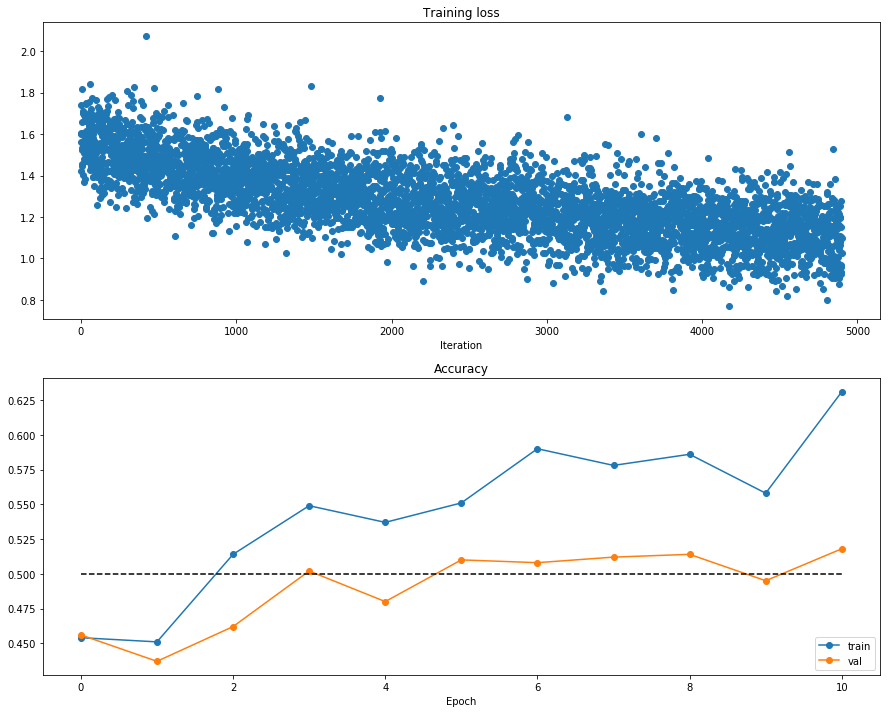

In [17]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [21]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.304933
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.132000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.155000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.161000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.101000
(Epoch 4 / 20) train acc: 0.360000; val_acc: 0.153000
(Epoch 5 / 20) train acc: 0.340000; val_acc: 0.145000
(Iteration 11 / 40) loss: 2.138307
(Epoch 6 / 20) train acc: 0.320000; val_acc: 0.151000
(Epoch 7 / 20) train acc: 0.320000; val_acc: 0.145000
(Epoch 8 / 20) train acc: 0.420000; val_acc: 0.154000
(Epoch 9 / 20) train acc: 0.420000; val_acc: 0.125000
(Epoch 10 / 20) train acc: 0.540000; val_acc: 0.163000
(Iteration 21 / 40) loss: 1.767305
(Epoch 11 / 20) train acc: 0.580000; val_acc: 0.157000
(Epoch 12 / 20) train acc: 0.720000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 0.660000; val_acc: 0.186000
(Epoch 14 / 20) train acc: 0.660000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 0.760000; val_acc: 0.215000
(Iteration 31 / 40) loss: 

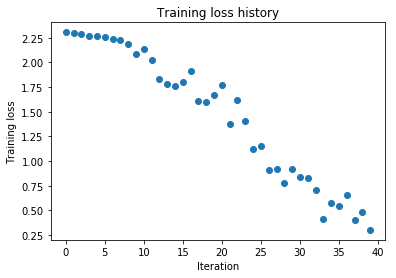

In [47]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 5e-3   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 38.310752
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.091000
(Epoch 1 / 20) train acc: 0.340000; val_acc: 0.082000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.153000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.144000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.133000
(Iteration 11 / 40) loss: 1.295090
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.120000
(Epoch 7 / 20) train acc: 0.900000; val_acc: 0.132000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.129000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.132000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.132000
(Iteration 21 / 40) loss: 0.001175
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.131000
(Iteration 31 / 40) loss:

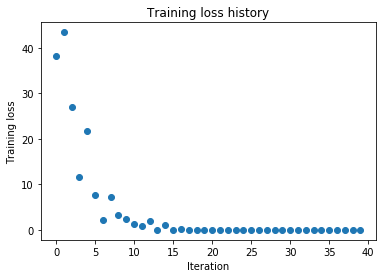

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302479
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302516
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

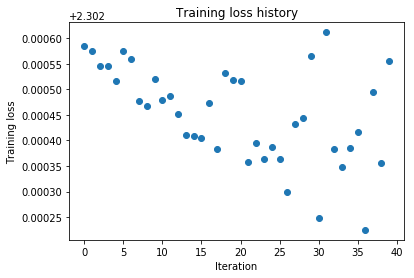

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302584
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302585
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

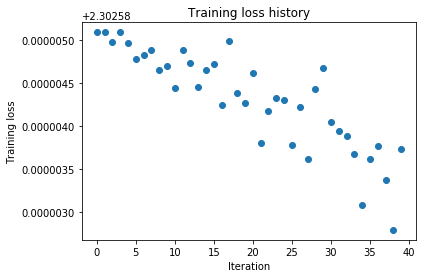

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.294175
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.280414
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

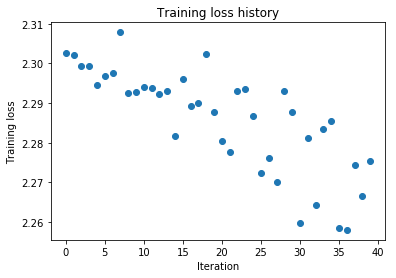

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302464
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302471
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

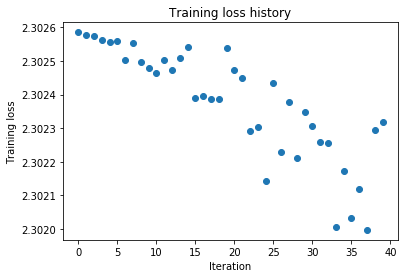

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302568
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302533
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

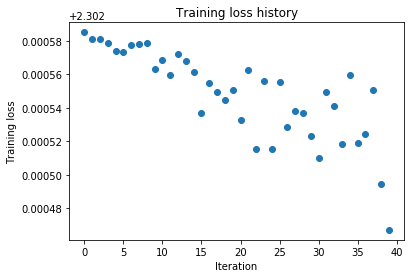

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.295114
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.300981
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

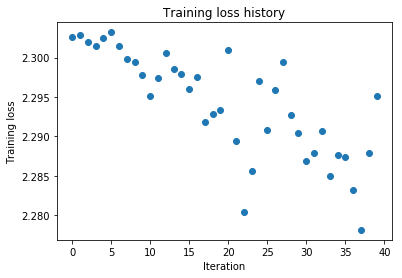

(Iteration 1 / 40) loss: 2.302588
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.131000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.125000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.118000
(Epoch 3 / 20) train acc: 0.140000; val_acc: 0.120000
(Epoch 4 / 20) train acc: 0.140000; val_acc: 0.142000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.142000
(Iteration 11 / 40) loss: 2.302532
(Epoch 6 / 20) train acc: 0.140000; val_acc: 0.142000
(Epoch 7 / 20) train acc: 0.140000; val_acc: 0.141000
(Epoch 8 / 20) train acc: 0.100000; val_acc: 0.137000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.136000
(Epoch 10 / 20) train acc: 0.180000; val_acc: 0.132000
(Iteration 21 / 40) loss: 2.302517
(Epoch 11 / 20) train acc: 0.200000; val_acc: 0.147000
(Epoch 12 / 20) train acc: 0.180000; val_acc: 0.127000
(Epoch 13 / 20) train acc: 0.200000; val_acc: 0.124000
(Epoch 14 / 20) train acc: 0.180000; val_acc: 0.109000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.101000
(Iteration 31 / 40) loss: 

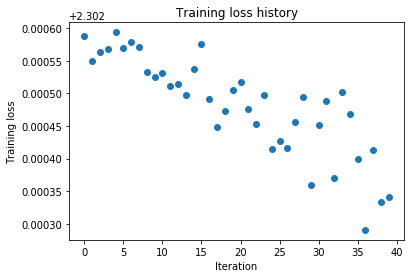

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.104000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.100000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.099000
(Epoch 3 / 20) train acc: 0.100000; val_acc: 0.098000
(Epoch 4 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 5 / 20) train acc: 0.140000; val_acc: 0.101000
(Iteration 11 / 40) loss: 2.302585
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.099000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.099000
(Epoch 8 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 9 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.077000
(Iteration 21 / 40) loss: 2.302584
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.077000
(Epoch 12 / 20) train acc: 0.120000; val_acc: 0.095000
(Epoch 13 / 20) train acc: 0.120000; val_acc: 0.095000
(Epoch 14 / 20) train acc: 0.100000; val_acc: 0.098000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

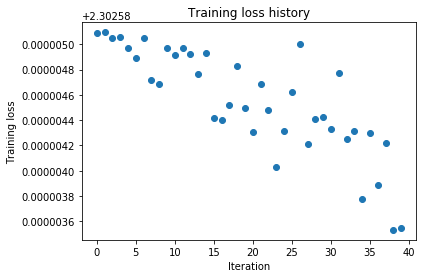

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302250
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.301798
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

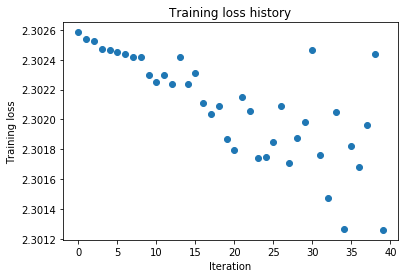

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302054
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.299769
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

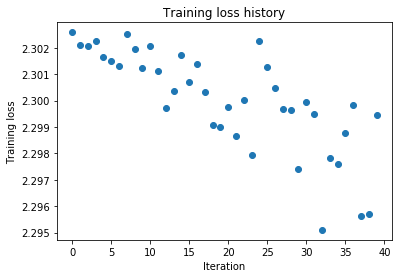

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302454
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302424
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

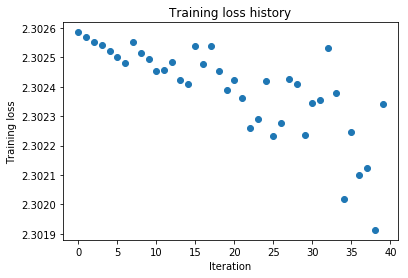

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302585
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.220000; val_acc: 0.088000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302584
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

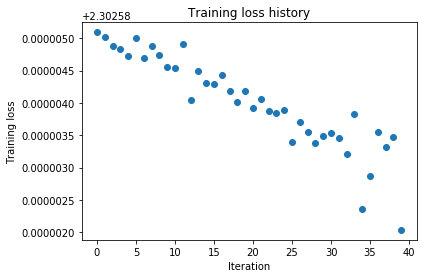

(Iteration 1 / 40) loss: 2.302504
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 1 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 2 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 3 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 4 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 5 / 20) train acc: 0.060000; val_acc: 0.109000
(Iteration 11 / 40) loss: 2.302622
(Epoch 6 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 7 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 8 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 9 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 10 / 20) train acc: 0.060000; val_acc: 0.109000
(Iteration 21 / 40) loss: 2.302345
(Epoch 11 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 12 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 13 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 14 / 20) train acc: 0.060000; val_acc: 0.109000
(Epoch 15 / 20) train acc: 0.060000; val_acc: 0.109000
(Iteration 31 / 40) loss: 

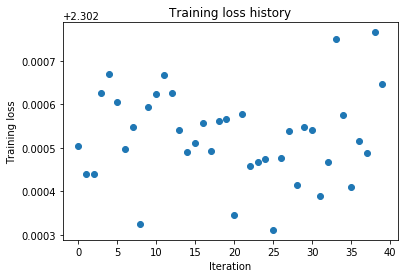

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.297828
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.293529
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

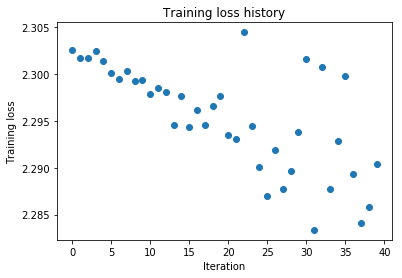

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.105000
(Iteration 11 / 40) loss: 2.302583
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302581
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

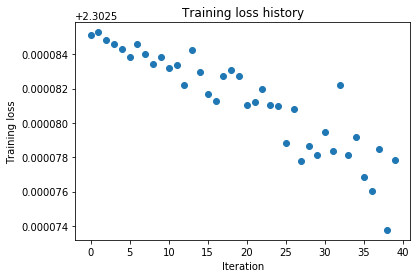

(Iteration 1 / 40) loss: 2.303787
(Epoch 0 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 1 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 2 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.020000; val_acc: 0.131000
(Epoch 4 / 20) train acc: 0.020000; val_acc: 0.131000
(Epoch 5 / 20) train acc: 0.020000; val_acc: 0.131000
(Iteration 11 / 40) loss: 2.301644
(Epoch 6 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 7 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 8 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 9 / 20) train acc: 0.020000; val_acc: 0.132000
(Epoch 10 / 20) train acc: 0.020000; val_acc: 0.132000
(Iteration 21 / 40) loss: 2.303572
(Epoch 11 / 20) train acc: 0.020000; val_acc: 0.133000
(Epoch 12 / 20) train acc: 0.020000; val_acc: 0.133000
(Epoch 13 / 20) train acc: 0.020000; val_acc: 0.131000
(Epoch 14 / 20) train acc: 0.020000; val_acc: 0.131000
(Epoch 15 / 20) train acc: 0.020000; val_acc: 0.131000
(Iteration 31 / 40) loss: 

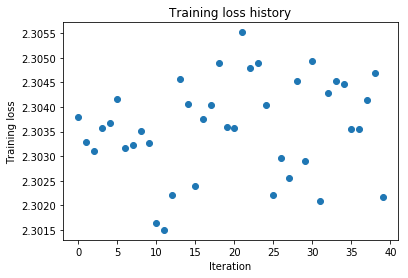

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302585
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302585
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

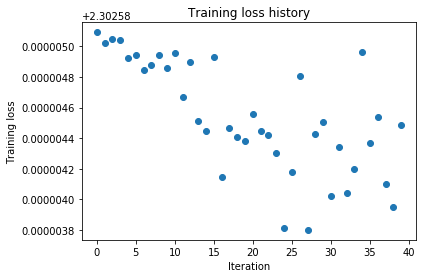

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302448
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302300
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

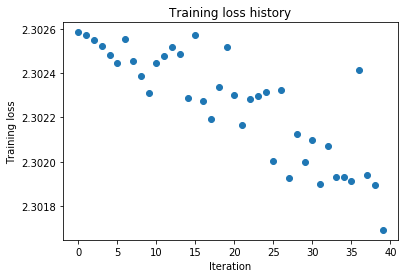

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302580
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302578
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

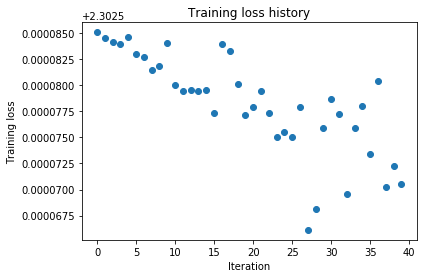

In [52]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

def getRandom(lr_min, lr_max, w_min, w_max):
    lr = 10**np.random.uniform(lr_min, lr_max)
    w = 10**np.random.uniform(w_min, w_max)
    return lr, w

for i in range(20):
    learning_rate, weight_scale = getRandom(-6, -1, -6, -1)

    # learning_rate = 2e-3  # Experiment with this!
    # weight_scale = 1e-5   # Experiment with this!
    model = FullyConnectedNet([100, 100, 100, 100],
                    weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=10, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    }
             )
    solver.train()
    print("lr: %e, w: %e" % (learning_rate, weight_scale))
    plt.plot(solver.loss_history, 'o')
    plt.title('Training loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [ ]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

In [ ]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
[FILL THIS IN]


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())